#Reinforcement Learning Project


---


*made by Alessandro Lambertini and Denise Landini*

*mat. 1938390 and 1938388*

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

# global variables to save the tables/models
dir = 'drive/MyDrive/Colab Notebooks/RL/Saves/'

dir_Qos = dir+'Q_our_solution_Tables/'

dir_QCarPole = dir_Qos+'Q_CarPole_Tables/'
dir_QTaxi = dir_Qos+'Q_Taxi_Tables/'

if not os.path.exists(dir):
  os.makedirs(dir)

if not os.path.exists(dir_Qos):
  os.makedirs(dir_Qos)
  
if not os.path.exists(dir_QCarPole):
  os.makedirs(dir_QCarPole)
if not os.path.exists(dir_QTaxi):
  os.makedirs(dir_QTaxi)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Import

In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null
!apt-get install -y x11-utils > /dev/null
!pip install pyvirtualdisplay > /dev/null
!pip install pyglet > /dev/null

In [2]:
import os
import base64
import time
import imageio
import random

import numpy as np

from pyvirtualdisplay import Display
import IPython
from IPython.display import display, clear_output#, HTML, clear_output

display = Display(visible=0, size=(1000, 600))
display.start()

import gym
from gym import ObservationWrapper
from gym.spaces import Discrete, Tuple

from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from collections import defaultdict, namedtuple
from functools import reduce

import cloudpickle as pickle

import cv2

import seaborn as sns

##Experiments on the update rule

###Env

In [3]:
class myEnviroment:
  def __init__(self, mapStr=None):
    if mapStr == None:
      #Map of the enviroment
      self.mapStr = np.array([
        np.array([*" █   █   █   █   █   █   █   █  0"]),
        np.array([*" █ █ █ ███ █ ███ █ █ █ █ ███ █   "]),
        np.array([*" █ █   █ █   █ █ █ █   █ █   ███ "]),
        np.array([*" █ █ ███ █ █ █   █ █ █ █ █ █ █ █ "]),
        np.array([*" █ █ █ █ █ █   █ █   █ █ █ █ █ █ "]),
        np.array([*" █   █ █☻  █ █ █ █ █ █   █ █ █ █ "]),
        np.array([*" █ █ █ █ ███ █ █   █ █ █ █ █ █ █ "]),
        np.array([*" █ █ █   █ █ █ █ █ ███ █ █ █ █   "]),
        np.array([*"   █   █   █   █  ☻    █   █     "]), ##
        np.array([*" █ █ █ █ █ █ ███ █ █ █ █ ███ █   "]),
        np.array([*" █ █   █ █   █ █ █ █   █ █   ███ "]),
        np.array([*" █ █ ███ █ █ █   █ █ █ █ █ █ █ █☻"]),
        np.array([*" █ █ █ █ █ █   █ █   █ █ █ █ █ █ "]),
        np.array([*" █   █ █   █ █ █ █ █ █   █ █ █ █ "]),
        np.array([*" █ █ █ █ ███ █ █   █ █ █ █ █ █ █ "]),
        np.array([*" █ █ █ █ █ █ █ █ █ ███ █ █ █ █   "]),
        np.array([*"   █   █   █   █       █   █     "])
        ])
    else:
      self.mapStr = mapStr
    
    # setting the rewards for the events
    self.stepBadReward = -1
    self.stepDiagonalBadReward = -1.5
    self.wallBadReward = -10
    self.enemyBadReward = -100
    self.badshootReward = -10
    self.enemyReward = 1
    self.goalReward = 300
    
    # counting how many enemy there are
    self.num_enemy = sum([1 if x == '☻' else 0 for r in self.mapStr for x in r])
    # Saving the enemies position
    self.enemy_pos = {(i, j): 1 for i in range(self.mapStr.shape[0]) for j in range(self.mapStr.shape[1]) if self.mapStr[i][j] == '☻'}
    # Setting the enemy position
    self.enemy_direction = {k: 1 for k in self.enemy_pos.keys()}

    # the size of the map is the first 2 parameters for the bins
    self._bins_env = (*self.mapStr.shape, 2**self.num_enemy)
    # the second part of the bins is set with a list of the power of 2, es num_enemy=3 _bins_enemy = [4, 2, 1]
    self._bins_enemy = tuple(2**i for i in reversed(range(self.num_enemy)))

    # Discretize the observation space
    self.observation_space = Discrete(np.prod(self._bins_env))
    # Setting the minimum to 0, 0 and the maximum to the size of the map
    self.observation_space.min = [0, 0]
    self.observation_space.max = [*self._bins_env[:2]]

    # For each action i save the corresponding name
    self.action_name = ["left", "top-left", "top", "top-right", "right", "bottom-right", "bottom", "bottom-left",
                        "shoot-left", "shoot-top", "shoot-right", "shoot-bottom"]
    # Discretize the action space
    self.action_space = Discrete(len(self.action_name))

    self.__inizialize__()

  def __inizialize__(self):
    # create a current map to be modified
    self.mat = np.full(self._bins_env[0:2], ' ')

    # Set the initial position
    while True:
      self.initPos = np.random.randint([0, 0], [*self._bins_env[:2]], size=2)
      if self.mapStr[self.initPos[0], self.initPos[1]] == ' ':
        break

    # copy some data to be modified
    self.currentPos = self.initPos
    self.current_num_enemy = self.num_enemy
    self.current_enemy_pos = self.enemy_pos.copy()
    self.current_enemy_direction = self.enemy_direction.copy()

    # Get the goal position
    for i in range(self.mapStr.shape[0]):
      for j in range(self.mapStr.shape[1]):
        if self.mapStr[i][j] == '0':
          self.goalPos = [i, j]
          break

    # modify mat based on the current state
    self.__drawCurrentPos__()
  
  def __drawCurrentPos__(self, oldPos = None):
    if oldPos == None:
      # modify all the data in mat
      for i in range(self._bins_env[0]):
        for j in range(self._bins_env[1]):
          self.mat[i][j] = self.mapStr[i][j]
      self.mat[self.currentPos[0], self.currentPos[1]] = '*'
    else:
      # modify only one position
      self.mat[oldPos[0], oldPos[1]] = ' '
      self.mat[self.currentPos[0], self.currentPos[1]] = '*'

  # render mat
  def render(self, mode='ansi'):
    if mode == 'ansi': # return a list of ansi
      out = ""
      for _ in range(self._bins_env[1]+2): out += "-"
      out += "\n"
      for r in range(self._bins_env[0]):
        out += '|'
        for c in range(self._bins_env[1]):
          out += self.mat[r][c]
        out += '|\n'
      for _ in range(self._bins_env[1]+2): out += "-"
      out += "\n"
      return out
    elif mode == 'rgb_array': # return a matrix of colors
      black = np.array([0, 0, 0], dtype=np.uint8)
      white = np.array([255, 255, 255], dtype=np.uint8)
      red = np.array([255, 0, 0], dtype=np.uint8)
      green = np.array([0, 255, 0], dtype=np.uint8)
      blue = np.array([0, 0, 255], dtype=np.uint8)
      out = np.zeros((self._bins_env[0]+2, self._bins_env[1]+2, 3), dtype=np.uint8)

      for r in range(self._bins_env[0]):
        for c in range(self._bins_env[1]):
          if self.mat[r][c] == ' ':
            out[r+1][c+1] = white
          elif self.mat[r][c] == '*':
            out[r+1][c+1] = red
          elif self.mat[r][c] == '☻':
            out[r+1][c+1] = blue
          elif self.mat[r][c] == '0':
            out[r+1][c+1] = green
      return cv2.resize(out, dsize=(512, 512), interpolation=cv2.INTER_NEAREST)

  # observation based on the current state of the enemies es enemies_alive = [1, 0, 1] return 5
  def observation_enemy(self):
    enemies_alive = [*self.current_enemy_pos.values()]
    return sum([ self._bins_enemy[i] * enemies_alive[i] for i in range(0, len(self._bins_enemy)) ])
  # observation based on the current position
  def observation_location(self, observation):
    return sum([ reduce(lambda x, y: x*y, self._bins_env[-i:]) * observation[-i] for i in reversed(range(1, len(self._bins_env))) ])
  # the returned observation is a concatenation between observation_location and observation_enemy
  def observation(self, observation):
    #return self.observation_enemy()*self._bins_env[0]*self._bins_env[1]+observation[0]*self._bins_env[1]+observation[1]
    return self.observation_location(observation) + self.observation_enemy()
    
  # reset the current enviroment
  def reset(self):
    self.__inizialize__()
    return self.observation(self.currentPos)
  
  # function to check if a position is a wall
  def __isWall__(self, i, j):
    return self.mat[i][j] == '█'
  # function to check if a position is an enemy
  def __isEnemy__(self, i, j):
    return self.mat[i][j] == '☻'
  #function to check if a shoot hit an enemy
  def __shootHit__(self, action, i, j):
    pos = self.mat[i][j]

    if action == 0: # shoot-left
      while (not pos == '█') and j >= self.observation_space.min[1]:
        pos = self.mat[i][j]
        if pos == '☻':
          self.current_num_enemy -= 1
          self.current_enemy_pos[(i, j)] = 0
          self.mat[i][j] = ' '
          return True
        j -= 1
    if action == 1: # shoot-top
      pos = self.mat[i][j]
      while (not pos == '█') and i >= self.observation_space.min[0]:
        pos = self.mat[i][j]
        if pos == '☻':
          self.current_num_enemy -= 1
          self.current_enemy_pos[(i, j)] = 0
          self.mat[i][j] = ' '
          return True
        i -= 1
    if action == 2: # shoot-right
      pos = self.mat[i][j]
      while (not pos == '█') and j < self.observation_space.max[1]:
        pos = self.mat[i][j]
        if pos == '☻':
          self.current_num_enemy -= 1
          self.current_enemy_pos[(i, j)] = 0
          self.mat[i][j] = ' '
          return True
        j += 1
    if action == 3: # shoot-bottom
      pos = self.mat[i][j]
      while (not pos == '█') and i < self.observation_space.max[0]:
        pos = self.mat[i][j]
        if pos == '☻':
          self.current_num_enemy -= 1
          self.current_enemy_pos[(i, j)] = 0
          self.mat[i][j] = ' '
          return True
        i += 1
    return False
  
  # function to check if an action is performable and to perform it
  def __performAction__(self, action):
    reward = 0
    done = False
    text = ""

    if action == 0: # left
      # Check walls and maps bounds
      if self.currentPos[1]-1 >= self.observation_space.min[1] \
          and not self.__isWall__(self.currentPos[0], self.currentPos[1]-1):
        # Check enemy position
        if not self.__isEnemy__(self.currentPos[0], self.currentPos[1]-1):
          self.mat[self.currentPos[0]][self.currentPos[1]] = ' '
          self.currentPos[1] -= 1
          self.mat[self.currentPos[0]][self.currentPos[1]] = '*'
          reward = self.stepBadReward
        else:
          reward = self.enemyBadReward
          done = True
      else:
        reward = self.wallBadReward
    elif action == 1: # top-left
      # Check walls and maps bounds
      if self.currentPos[1]-1 >= self.observation_space.min[1] \
          and self.currentPos[0]-1 >= self.observation_space.min[0] \
          and not self.__isWall__(self.currentPos[0]-1, self.currentPos[1]-1):
        # Check enemy position
        if not self.__isEnemy__(self.currentPos[0]-1, self.currentPos[1]-1):
          self.mat[self.currentPos[0]][self.currentPos[1]] = ' '
          self.currentPos[0] -= 1
          self.currentPos[1] -= 1
          self.mat[self.currentPos[0]][self.currentPos[1]] = '*'
          reward = self.stepDiagonalBadReward
        else:
          reward = self.enemyBadReward
          done = True
      else:
        reward = self.wallBadReward
    elif action == 2: # top
      # Check walls and maps bounds
      if self.currentPos[0]-1 >= self.observation_space.min[0] \
          and not self.__isWall__(self.currentPos[0]-1, self.currentPos[1]):
        # Check enemy position
        if not self.__isEnemy__(self.currentPos[0]-1, self.currentPos[1]):
          self.mat[self.currentPos[0]][self.currentPos[1]] = ' '
          self.currentPos[0] -= 1
          self.mat[self.currentPos[0]][self.currentPos[1]] = '*'
          reward = self.stepBadReward
        else:
          reward = self.enemyBadReward
          done = True
      else:
        reward = self.wallBadReward
    elif action == 3: # top-right
      # Check walls and maps bounds
      if self.currentPos[0]-1 >= self.observation_space.min[0] \
          and self.currentPos[1]+1 < self.observation_space.max[1] \
          and not self.__isWall__(self.currentPos[0]-1, self.currentPos[1]+1):
        # Check enemy position
        if not self.__isEnemy__(self.currentPos[0]-1, self.currentPos[1]+1):
          self.mat[self.currentPos[0]][self.currentPos[1]] = ' '
          self.currentPos[0] -= 1
          self.currentPos[1] += 1
          self.mat[self.currentPos[0]][self.currentPos[1]] = '*'
          reward = self.stepDiagonalBadReward
        else:
          reward = self.enemyBadReward
          done = True
      else:
        reward = self.wallBadReward
    elif action == 4: # right
      # Check walls and maps bounds
      if self.currentPos[1]+1 < self.observation_space.max[1] \
          and not self.__isWall__(self.currentPos[0], self.currentPos[1]+1):
        # Check enemy position
        if not self.__isEnemy__(self.currentPos[0], self.currentPos[1]+1):
          self.mat[self.currentPos[0]][self.currentPos[1]] = ' '
          self.currentPos[1] += 1
          self.mat[self.currentPos[0]][self.currentPos[1]] = '*'
          reward = self.stepBadReward
        else:
          reward = self.enemyBadReward
          done = True
      else:
        reward = self.wallBadReward
    elif action == 5: # bottom-right
      # Check walls and maps bounds
      if self.currentPos[0]+1 < self.observation_space.max[0] \
          and self.currentPos[1]+1 < self.observation_space.max[1] \
          and not self.__isWall__(self.currentPos[0]+1, self.currentPos[1]+1):
        # Check enemy position
        if not self.__isEnemy__(self.currentPos[0]+1, self.currentPos[1]+1):
          self.mat[self.currentPos[0]][self.currentPos[1]] = ' '
          self.currentPos[0] += 1
          self.currentPos[1] += 1
          self.mat[self.currentPos[0]][self.currentPos[1]] = '*'
          reward = self.stepDiagonalBadReward
        else:
          reward = self.enemyBadReward
          done = True
      else:
        reward = self.wallBadReward
    elif action == 6: # bottom
      # Check walls and maps bounds
      if self.currentPos[0]+1 < self.observation_space.max[0] \
          and not self.__isWall__(self.currentPos[0]+1, self.currentPos[1]):
        # Check enemy position
        if not self.__isEnemy__(self.currentPos[0]+1, self.currentPos[1]):
          self.mat[self.currentPos[0]][self.currentPos[1]] = ' '
          self.currentPos[0] += 1
          self.mat[self.currentPos[0]][self.currentPos[1]] = '*'
          reward = self.stepBadReward
        else:
          reward = self.enemyBadReward
          done = True
      else:
        reward = self.wallBadReward
    elif action == 7: # bottom-left
      # Check walls and maps bounds
      if self.currentPos[0]+1 < self.observation_space.max[0] \
          and self.currentPos[1]-1 >= self.observation_space.min[1] \
          and not self.__isWall__(self.currentPos[0]+1, self.currentPos[1]-1):
        # Check enemy position
        if not self.__isEnemy__(self.currentPos[0]+1, self.currentPos[1]-1):
          self.mat[self.currentPos[0]][self.currentPos[1]] = ' '
          self.currentPos[0] += 1
          self.currentPos[1] -= 1
          self.mat[self.currentPos[0]][self.currentPos[1]] = '*'
          reward = self.stepDiagonalBadReward
        else:
          reward = self.enemyBadReward
          done = True
      else:
        reward = self.wallBadReward

    elif action == 8: # shoot-left
      # Check if shoot hit an enemy
      if self.__shootHit__(0, *self.currentPos):
        reward = self.enemyReward
      else:
        reward = self.badshootReward
    elif action == 9: # shoot-top
      # Check if shoot hit an enemy
      if self.__shootHit__(1, *self.currentPos):
        reward = self.enemyReward
      else:
        reward = self.badshootReward
    elif action == 10: # shoot-right
      # Check if shoot hit an enemy
      if self.__shootHit__(2, *self.currentPos):
        reward = self.enemyReward
      else:
        reward = self.badshootReward
    elif action == 11: # shoot-bottom
      # Check if shoot hit an enemy
      if self.__shootHit__(3, *self.currentPos):
        reward = self.enemyReward
      else:
        reward = self.badshootReward
    
    info = {"text": text}
    return reward, done, info

  # perform anemy movement, at each action taken from the agent the enemies will move one step forward
  def __moveEnemies__(self):
    appDict = self.current_enemy_pos.copy()
    for k, v in appDict.items():
      # check if enemy is alive
      if v == 1:
        # enemy goes up
        if self.current_enemy_direction[k] == 0:
          next_pos = (k[0]-1, k[1])
          # check walls and map bounds
          if next_pos[0] >= self.observation_space.min[0] and self.mat[next_pos[0]][next_pos[1]] == ' ':
            self.current_enemy_pos[next_pos] = 1
            self.current_enemy_direction[next_pos] = 0
            self.mat[next_pos[0]][next_pos[1]] = '☻'
            del self.current_enemy_pos[k]
            del self.current_enemy_direction[k]
            self.mat[k[0]][k[1]] = ' '
          # check agent position
          elif next_pos[0] >= self.observation_space.min[0] and self.mat[next_pos[0]][next_pos[1]] == '*':
            return True
          else:
            # now the enemy goes down
            self.current_enemy_direction[k] = 1
        # enemy goes down
        elif self.current_enemy_direction[k] == 1:
          next_pos = (k[0]+1, k[1])
          # check walls and map bounds
          if next_pos[0] < self.observation_space.max[0] and self.mat[next_pos[0]][next_pos[1]] == ' ':
            self.current_enemy_pos[next_pos] = 1
            self.current_enemy_direction[next_pos] = 1
            self.mat[next_pos[0]][next_pos[1]] = '☻'
            del self.current_enemy_pos[k]
            del self.current_enemy_direction[k]
            self.mat[k[0]][k[1]] = ' '
          # check agent position
          elif next_pos[0] < self.observation_space.max[0] and self.mat[next_pos[0]][next_pos[1]] == '*':
            return True
          else:
            # now the enemy goes up
            self.current_enemy_direction[k] = 0
    return False
  
  # perform action, return next_observation, reward and done
  def step(self, action):
    reward, done, info = self.__performAction__(action)
    if self.__moveEnemies__():
      done = True
      reward -= self.enemyBadReward

    next_observation = self.observation(self.currentPos)
    
    if all(self.currentPos == self.goalPos):
      reward = self.goalReward
      done = True

    return next_observation, reward, done, info

###Class

In [4]:
class myEnv:
  def __init__(self, env, α, γ, ε_init_value, ε_final_value, ε_tot_epochs, Kq):
    self.env = env
    
    self._α = α # Learning rate
    self._γ = γ # Discount factor

    # Exploration
    self._ε_init_value = ε_init_value
    self._ε_final_value = ε_final_value
    self._ε_tot_epochs = ε_tot_epochs
    
    # Arrays to save execution times and rewards during training
    self.times = []
    self.rewards = []

    # Q table and H table
    self._Q = np.zeros(shape=(self.env.observation_space.n, self.env.action_space.n))
    self._H = defaultdict(lambda: np.zeros(shape=self._Q.shape))
    #self._H2 = defaultdict(lambda: np.zeros(shape=self._Q.shape[0]))
    #["left", "top-left", "top", "top-right", "right", "bottom-right", "bottom", "bottom-left", "shoot-left", "shoot-top", "shoot-right", "shoot-bottom"]
    #[  0,        1,        2,        3,          4,          5,           6,         7,              8,            9,          10,             11]
    
    # Our implementation of _H
    self._actionConverter = {0:0, 2:0, 4:0, 6:0, 1:1, 3:1, 5:1, 7:1, 8:2, 9:2, 10:2, 11:2}
    self._H3 = defaultdict(lambda: np.zeros(shape=(self._Q.shape[0], 3) ))

    self.Kq = Kq # Important of expected_reward
    self._H4_t = defaultdict(lambda: np.zeros(shape=self._Q.shape))

  # return the next action to do based on the current observation
  def policy(self, current_observation):
    return np.argmax(self._Q[current_observation])
  
  # Return the value of the exploration time based on the current epoch in a linear way
  def explorationValue(self, epoch):
    epochs_progress = epoch/self._ε_tot_epochs
    if epochs_progress > 1:
      return self._ε_final_value
    return self._ε_init_value + epochs_progress * (self._ε_final_value - self._ε_init_value)

  # return the time between 2 intervals
  def elapsedTime(self, start):
    done = time.time()
    elapsed = done - start
    self.times.append(elapsed)
    return elapsed
  
  # Saves the Q and H table
  def save(self, path="./", name='values'):
    np.save(path+name+'_Q', self._Q, allow_pickle=True)
    np.savez(path+name+'_H', dict(self._H), allow_pickle=True)
    np.savez(path+name+'_H3', dict(self._H3), allow_pickle=True)
    np.savez(path+name+'_H4_t', dict(self._H4_t), allow_pickle=True)

  # Load the Q and H table
  def load(self, path="./", name='values'):
    self._Q[:] = np.load(path+name+'_Q.npy', allow_pickle=True)
    with np.load(path+name+'_H.npz', allow_pickle = True) as data:
            self._H.update(data['arr_0'].item())
    with np.load(path+name+'_H3.npz', allow_pickle = True) as data:
            self._H3.update(data['arr_0'].item())
    with np.load(path+name+'_H4_t.npz', allow_pickle = True) as data:
            self._H4_t.update(data['arr_0'].item())

  def train(self, tot_epochs_train, max_epoch_step, print_info=False, print_info_episodes=100, print_plt_state=False):
    # inizialize data for time execution ad rewards
    start = time.time()
    epoch_reward = 0

    # starting main loop for training
    for epoch in range(1, tot_epochs_train+1):
      # inizialize data
      step = 0 # number of actions done in this epoch
      done = False # bool to check termination
      current_observation = self.env.reset() # starting the enviroment

      # TEST
      #last10steps = np.full(10, np.NaN)
      #last10steps[step%10] = current_observation
      
      # do actions until the agent terminate or has done enough steps
      while not done and step < max_epoch_step:
        # the agent pick an action
        if np.random.random_sample() > self.explorationValue(epoch):
          # random action
          action = self.policy(current_observation)
        else:
          # action based on the policy
          action = self.env.action_space.sample()
        
        # Perform action
        next_observation, reward, done, _info = self.env.step(action)

        # TEST
        #if next_observation in last10steps:
        #  reward -= 100
        #  last10steps = np.full(10, np.NaN)
        #last10steps[(step+1)%10] = next_observation

        argmax_a = np.argmax(self._Q[next_observation])

        # Compute data to evaluate expected_reward and intent_update used to update Q and H
        expected_reward = reward + self._γ * np.max(self._Q[next_observation]) *\
            (1-int(done)) - self._Q[current_observation, action]
        intent_update = np.zeros(self._Q.shape)

        intent_update[current_observation, action] += 1
        expected_intent = intent_update + self._γ * self._H[next_observation, argmax_a] *\
            (1-int(done)) - self._H[current_observation, action]
        del intent_update
        
        # update Q and H
        self._Q[current_observation, action] += self._α * expected_reward
        self._H[current_observation, action] = self._H[current_observation, action] +\
            self._α * expected_intent
        del expected_intent
        
        # OLD TEST
        #intent_update2 = np.zeros(self._Q.shape[0])
        #intent_update2[current_observation] += 1
        #expected_intent2 = intent_update2 + self._γ * self._H2[next_observation] *\
        #    (1-int(done)) - self._H2[current_observation]
        #del intent_update2
        #self._H2[current_observation] = self._H2[current_observation] +\
        #    self._α * expected_intent2
        
        # Compute data to evaluate intent_update3 and expected_intent3 used to update H3
        #
        # in this case we group up the actions in 3 classes:
        # 1) vertical/horizontal movements ["left", "top", "right", "bottom"]
        # 2) diagonal movements            ["top-left", "top-right", "bottom-right", "bottom-left"]
        # 3) shoot                         ["shoot-left", "shoot-top", "shoot-right", "shoot-bottom"]
        action3 = self._actionConverter[action]
        argmax_a3 = self._actionConverter[argmax_a]
        intent_update3 = np.zeros( (self._Q.shape[0], 3) )
        intent_update3[current_observation, action3] += 1
        expected_intent3 = intent_update3 + self._γ * self._H3[next_observation, argmax_a3] *\
            (1-int(done)) - self._H3[current_observation, action3]
        del intent_update3

        # update H3
        self._H3[current_observation, action3] = self._H3[current_observation, action3] +\
            self._α * expected_intent3
        del expected_intent3

        # OLD TEST
        #one = np.zeros(mEnv._Q.shape)
        #one[current_observation, action] += 1
        #expected_intent = one + self._γ * self._H[next_observation, argmax_a] - self._H[current_observation, action]
        #self._e4[current_observation, action] = self._e4[current_observation, action]/np.mean(self._H4_t[current_observation, action])*\
        #    (self._H4_t[current_observation, action]-self._H4_t[next_observation, argmax_a])
        #self._H4_t[current_observation, action] = self.Kd*(one + self._H4_t[current_observation, action] + one*self._H4_t[next_observation, argmax_a]) +\
        #    self.Kp*self._e4[current_observation, action]
        #del one

        # Compute data to evaluate intent_update4 and expected_intent4 used to update H4
        intent_update4 = np.zeros(self._Q.shape)
        intent_update4[current_observation, action] += 1
        expected_intent4 = intent_update4 + self._γ * self._H4_t[next_observation, argmax_a]*(1-int(done)) -\
            self._H4_t[current_observation, action]
        del intent_update4

        # update H4
        #
        # in this case we used also the expected_reward to evaluate H4
        self._H4_t[current_observation, action] += self._α * expected_intent4 + self.Kq * expected_reward
        del expected_intent4

        # update data for the loop
        current_observation = next_observation
        step += 1
        epoch_reward += reward
      
      # Print informations for the training
      if print_info and (epoch) % print_info_episodes == 0:
        avgReward = epoch_reward/print_info_episodes
        epoch_reward = 0
        self.rewards.append(avgReward)
        print("Episode %d, reward: %f,  time: %f s" %(epoch, avgReward, self.elapsedTime(start)))

        if print_plt_state:
          data = np.reshape(mEnv._H[2183  , 11], (*mEnv.env._bins_env, 12))[:, : ,3, :]
          simbols = ["⬅", "⬉", "⬆", "⬈", "➡", "⬊", "⬇", "⬋", "◀", "▲", "▶", "▼"]
          appDataH = np.zeros(data.shape[:-1])
          ll = np.empty(appDataH.shape, dtype="<U6")
          for i in range(len(data)):
              for j in range(len(data[i])):
                if (mEnv.env.mapStr[i][j] == '█'):
                  appDataH[i][j] = -2
                  ll[i][j] = "█"
                elif all(data[i][j] == 0.0):
                  appDataH[i][j] = -1
                  if (mEnv.env.mat[i][j] == '*'):
                    ll[i][j] = "*"
                  elif (mEnv.env.mat[i][j] == '☻'):
                    ll[i][j] = "☻"
                  else:
                    ll[i][j] = " "
                else:
                  appDataH[i][j] = data[i][j].argmax()
                  if (mEnv.env.mat[i][j] == '*'):
                    ll[i][j] = "*\n"+simbols[int(appDataH[i][j])]
                  elif (mEnv.env.mat[i][j] == '☻'):
                    ll[i][j] = "☻\n"+simbols[int(appDataH[i][j])]
                  else:
                    ll[i][j] = simbols[int(appDataH[i][j])]
          
          data2 = np.reshape(mEnv._H[2127, 4], (*mEnv.env._bins_env, 12))[:, : ,7, :]
          appDataH2 = np.zeros(data2.shape[:-1])
          ll2 = np.empty(appDataH2.shape, dtype="<U6")
          for i in range(len(data2)):
              for j in range(len(data2[i])):
                if (mEnv.env.mapStr[i][j] == '█'):
                  appDataH2[i][j] = -2
                  ll2[i][j] = "█"
                elif all(data2[i][j] == 0.0):
                  appDataH2[i][j] = -1
                  if (mEnv.env.mat[i][j] == '*'):
                    ll2[i][j] = "*"
                  elif (mEnv.env.mat[i][j] == '☻'):
                    ll2[i][j] = "☻"
                  else:
                    ll2[i][j] = " "
                else:
                  appDataH2[i][j] = data2[i][j].argmax()
                  if (mEnv.env.mat[i][j] == '*'):
                    ll2[i][j] = "*\n"+simbols[int(appDataH2[i][j])]
                  elif (mEnv.env.mat[i][j] == '☻'):
                    ll2[i][j] = "☻\n"+simbols[int(appDataH2[i][j])]
                  else:
                    ll2[i][j] = simbols[int(appDataH2[i][j])]
          
          data3 = np.reshape(mEnv._H4_t[2183  , 11], (*mEnv.env._bins_env, 12))[:, : ,3, :]
          appDataH3 = np.zeros(data3.shape[:-1])
          ll3 = np.empty(appDataH3.shape, dtype="<U6")
          for i in range(len(data3)):
              for j in range(len(data3[i])):
                if (mEnv.env.mapStr[i][j] == '█'):
                  appDataH3[i][j] = -2
                  ll3[i][j] = "█"
                elif all(data3[i][j] == 0.0) or all( data3[i][j][k] == data3[i][j][k+1] for k in range(len(data3[i][j])-1) ):
                  appDataH3[i][j] = -1
                  if (mEnv.env.mat[i][j] == '*'):
                    ll3[i][j] = "*"
                  elif (mEnv.env.mat[i][j] == '☻'):
                    ll3[i][j] = "☻"
                  else:
                    ll3[i][j] = " "
                else:
                  appDataH3[i][j] = data3[i][j].argmax()
                  if (mEnv.env.mat[i][j] == '*'):
                    ll3[i][j] = "*\n"+simbols[int(appDataH3[i][j])]
                  elif (mEnv.env.mat[i][j] == '☻'):
                    ll3[i][j] = "☻\n"+simbols[int(appDataH3[i][j])]
                  else:
                    ll3[i][j] = simbols[int(appDataH3[i][j])]

          f, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), dpi=80)
          ax[0].title.set_text("H[2183  , 11]")
          ax[0] = sns.heatmap(appDataH, cmap='gist_rainbow', linewidths=1.0, xticklabels=np.arange(data.shape[1]), yticklabels=np.arange(data.shape[0]), cbar=False, annot=ll, annot_kws={"fontsize":16}, fmt='', square=True, ax=ax[0], cbar_ax = ax[0])
          cbar1 = ax[0].figure.colorbar(ax[0].collections[0], orientation='horizontal', ax=ax[0])
          cbar1.set_ticks([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
          cbar1.set_ticklabels(["█", "N", *mEnv.env.action_name])

          ax[1].title.set_text("H[8  , 1]")
          ax[1] = sns.heatmap(appDataH2, cmap='gist_rainbow', linewidths=1.0, xticklabels=np.arange(data2.shape[1]), yticklabels=np.arange(data2.shape[0]), cbar=False, annot=ll2, annot_kws={"fontsize":16}, fmt='', square=True, ax=ax[1], cbar_ax = ax[1])
          cbar2 = ax[1].figure.colorbar(ax[1].collections[0], orientation='horizontal', ax=ax[1])
          cbar2.set_ticks([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
          cbar2.set_ticklabels(["█", "N", *mEnv.env.action_name])

          ax[2].title.set_text("H4[2183  , 11]")
          ax[2] = sns.heatmap(appDataH3, cmap='gist_rainbow', linewidths=1.0, xticklabels=np.arange(data3.shape[1]), yticklabels=np.arange(data3.shape[0]), cbar=False, annot=ll3, annot_kws={"fontsize":16}, fmt='', square=True, ax=ax[2], cbar_ax = ax[2])
          cbar3 = ax[2].figure.colorbar(ax[2].collections[0], orientation='horizontal', ax=ax[2])
          cbar3.set_ticks([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
          cbar3.set_ticklabels(["█", "N", *mEnv.env.action_name])
          plt.show()

        start = time.time()
    
   # Function used to test the trained agent
  def testText(self, max=50):
    frames = []
    current_observation = self.env.reset()
    done = False
    limit = 0
    actions = self.env.action_name
    sum_reward = 0
    print(limit, max)
    while not done and limit < max:
      action = self.policy(current_observation)
      next_observation, reward, done, _info = self.env.step(action)

      self.env.render(mode='ansi')

      current_observation = next_observation
      limit += 1
      sum_reward += reward

      frames.append({
        'frame': str(self.env.render(mode='ansi')),
        'observation': next_observation,
        'action': actions[action],
        'reward': sum_reward
        })
    def print_frames(frames):
      for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(.5)
    return print_frames(frames)

  # Function used to test the trained agent
  def testVideo(self, initPos=None, filename = None, max = 100):
    # create a new File video
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=30) as video:
      # Restart the enviroment
      current_observation = self.env.reset()
      # if needed set the initial position and the current position
      if not all(initPos == None):
        self.env.initPos = initPos
        self.env.currentPos = initPos
        self.env.__drawCurrentPos__()
      # add the current state of the enviroment
      video.append_data(self.env.render(mode='rgb_array'))
      # init data for the loop
      done = False
      actions = self.env.action_name
      limit = 0
      app = 0
      app3 = 0
      while not done and limit < max:
        # takes an action based on the policy
        action = self.policy(current_observation)
        action3 = self._actionConverter[action]
        # perform action
        next_observation, reward, done, _info = self.env.step(action)
        current_observation = next_observation

        # add the current state of the enviroment
        video.append_data(self.env.render(mode='rgb_array'))
        limit += 1
    def embed_mp4(filename):
      """Embeds an mp4 file in the notebook."""
      video = open(filename,'rb').read()
      b64 = base64.b64encode(video)
      tag = '''
      <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
      Your browser does not support the video tag.
      </video>'''.format(b64.decode())

      return IPython.display.HTML(tag)
    return embed_mp4(filename)

###Test

In [5]:
env = myEnviroment() # enviroment

print("observation_space: ", env.observation_space)
print("num observation_space: ", env.observation_space.n)
print("_bins_env: ", env._bins_env)
print("_bins_enemy: ", env._bins_enemy)
print("bins prod: ", Discrete(np.prod(env._bins_env)))

α = 0.1 # learning rate
γ = 1.0 # discount factor

ε_init_value = 1 # exploration probability
ε_final_value = 0.1 # final exploration value
ε_tot_epochs = 500 # number of epochs decay

Kq = 0.01 # Important of expected_reward

mEnv = myEnv(env, α, γ, ε_init_value, ε_final_value, ε_tot_epochs, Kq)

print("Shape Q: ", mEnv._Q.shape)
print("Shape mat: ", mEnv.env.mat.shape)
print("goal position: ", mEnv.env.goalPos)
print("num enemy: ", mEnv.env.current_num_enemy, " positions: ", mEnv.env.current_enemy_pos)

observation_space:  Discrete(4488)
num observation_space:  4488
_bins_env:  (17, 33, 8)
_bins_enemy:  (4, 2, 1)
bins prod:  Discrete(4488)
Shape Q:  (4488, 12)
Shape mat:  (17, 33)
goal position:  [0, 32]
num enemy:  3  positions:  {(5, 8): 1, (8, 18): 1, (11, 32): 1}


Episode 10, reward: -1155.400000,  time: 2.117870 s
Episode 20, reward: -1302.450000,  time: 2.288310 s
Episode 30, reward: -1345.750000,  time: 2.301462 s
Episode 40, reward: -1448.350000,  time: 2.262171 s
Episode 50, reward: -1337.700000,  time: 2.314282 s
Episode 60, reward: -1117.250000,  time: 1.976554 s
Episode 70, reward: -602.550000,  time: 1.103795 s
Episode 80, reward: -1061.600000,  time: 1.764009 s
Episode 90, reward: -1224.650000,  time: 2.014946 s
Episode 100, reward: -996.900000,  time: 1.770461 s
Episode 110, reward: -1150.500000,  time: 2.079265 s
Episode 120, reward: -918.500000,  time: 1.565638 s
Episode 130, reward: -1067.250000,  time: 1.797021 s
Episode 140, reward: -1290.750000,  time: 2.197696 s
Episode 150, reward: -1120.050000,  time: 1.988144 s
Episode 160, reward: -871.850000,  time: 1.641037 s
Episode 170, reward: -1088.650000,  time: 2.009953 s
Episode 180, reward: -704.000000,  time: 1.394729 s
Episode 190, reward: -723.950000,  time: 1.430429 s
Episode 

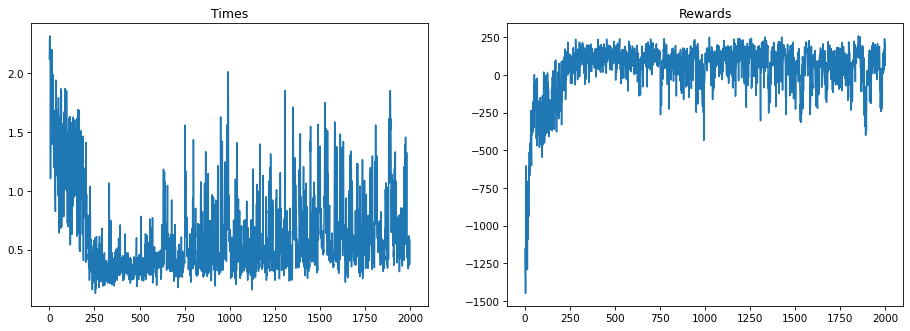

In [6]:
tot_epochs_train = 20000 # number fo epochs
max_epoch_step=200 # 200 # number of steps to terminate an epoch

# train the agent
mEnv.train(tot_epochs_train, max_epoch_step, print_info=True, print_info_episodes=10, print_plt_state=False)

# plot time exection and rewards over time
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=75)
ax[0].title.set_text("Times")
ax[0].plot(mEnv.times)
ax[1].title.set_text("Rewards")
ax[1].plot(mEnv.rewards)
plt.show()

In [ ]:
mEnv.save(path=dir_Qos)

In [ ]:
mEnv.load(path=dir_Qos)

In [ ]:
mEnv.testText(max = 200)

In [7]:
initPos=np.array([0, 0])
mEnv.testVideo(initPos=initPos, filename = "QCarPole00", max = 200)

In [9]:
initPos=np.array([None, None])
mEnv.testVideo(initPos=initPos, filename = "QCarPole", max = 200)

in the section below we show the data inside the table: H, H3 and H4

*   in the first plot we have H, we can notice that H has some problems after the agent has killed an enemy.

*   the plot in the second colum is H3, in this case we can notice that we have more information about what tha agent could do, but their are less precise.

*   in the third plot we have H4, in this case we have a resoult with less information with respect to H but we are more precise.
also we have that after the agent has killed an enemy we have more precise data.

state:  4471  action:  0  action3:  0  action_n:  left  Pos:  [16 29]  obs enemy: 7
state:  4463  action:  1  action3:  1  action_n:  top-left  Pos:  [15 28]  obs enemy: 7
state:  4191  action:  2  action3:  0  action_n:  top  Pos:  [14 28]  obs enemy: 7
state:  3927  action:  2  action3:  0  action_n:  top  Pos:  [13 28]  obs enemy: 7
state:  3663  action:  2  action3:  0  action_n:  top  Pos:  [12 28]  obs enemy: 7
state:  3399  action:  2  action3:  0  action_n:  top  Pos:  [11 28]  obs enemy: 7
state:  3135  action:  1  action3:  1  action_n:  top-left  Pos:  [10 27]  obs enemy: 7
state:  2863  action:  3  action3:  1  action_n:  top-right  Pos:  [ 9 28]  obs enemy: 7
state:  2607  action:  3  action3:  1  action_n:  top-right  Pos:  [ 8 29]  obs enemy: 7
state:  2351  action:  4  action3:  0  action_n:  right  Pos:  [ 8 30]  obs enemy: 7
state:  2359  action:  3  action3:  1  action_n:  top-right  Pos:  [ 7 31]  obs enemy: 7
state:  2103  action:  3  action3:  1  action_n:  top-ri

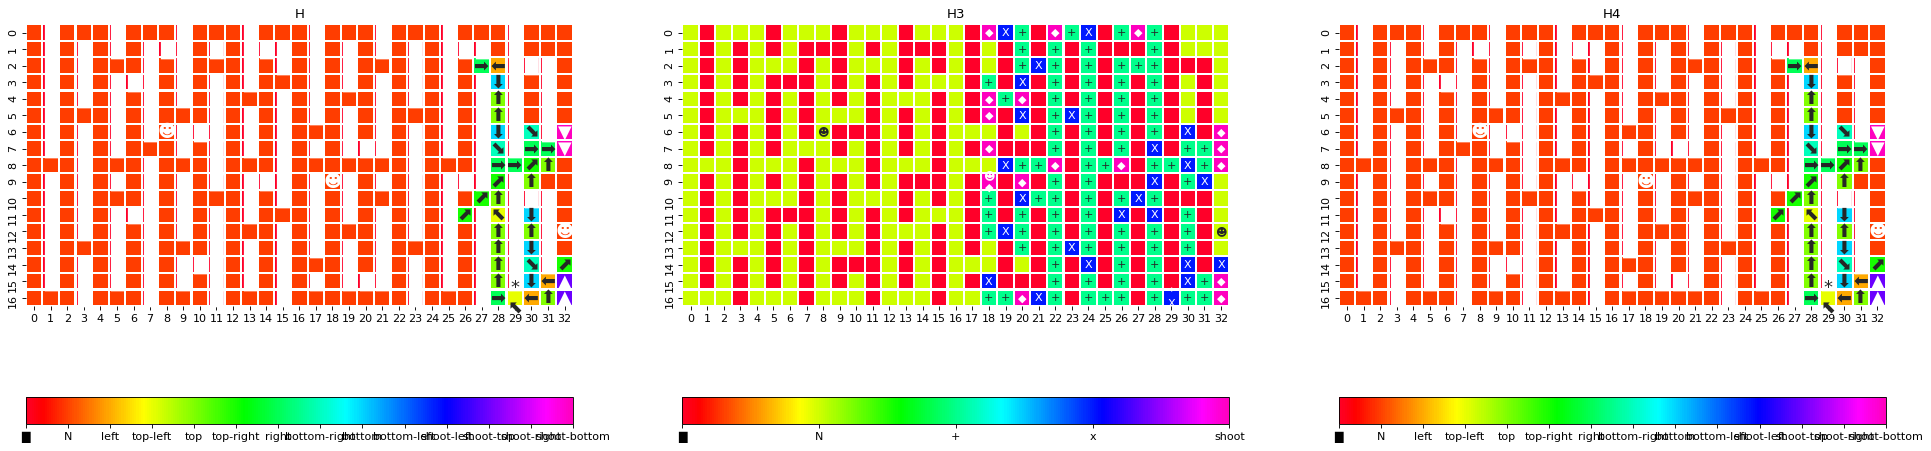

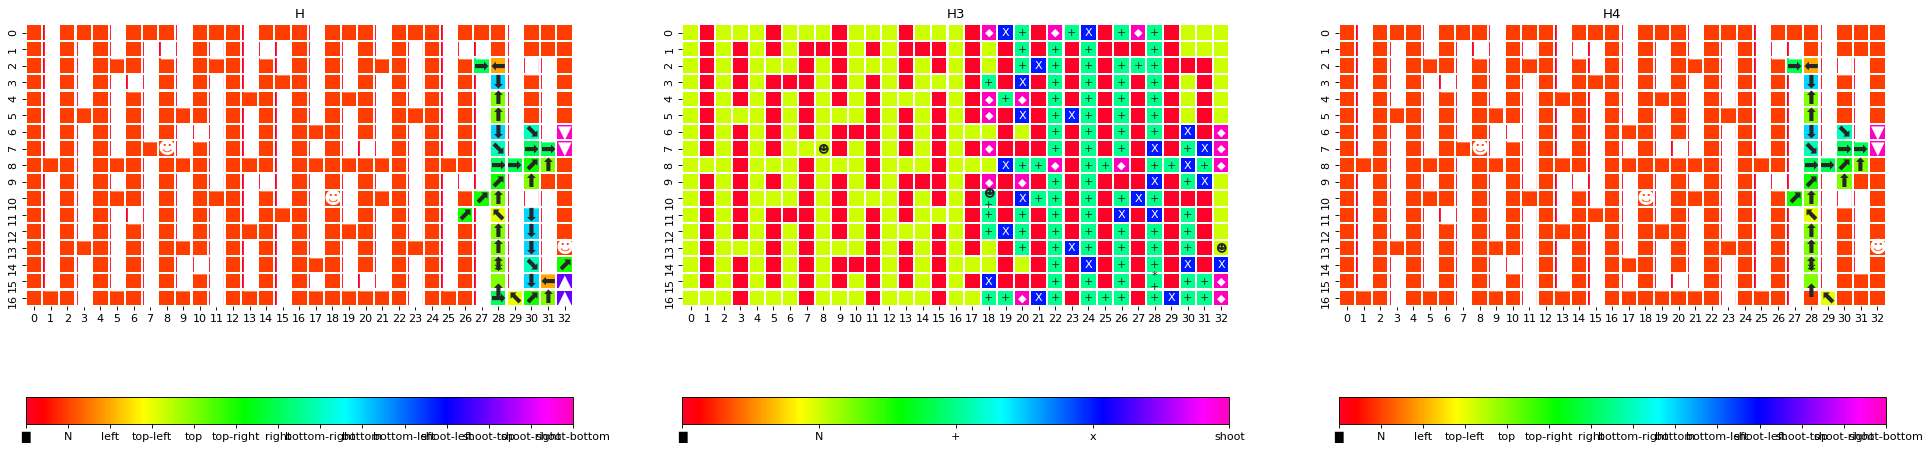

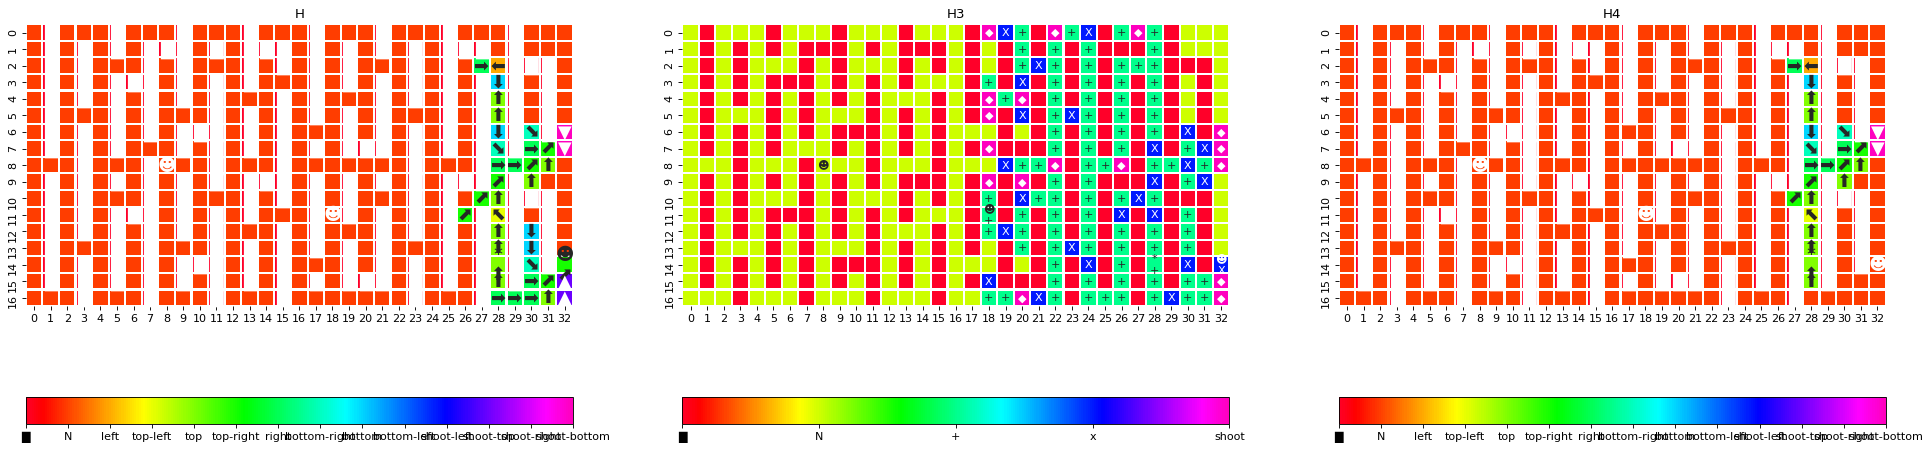

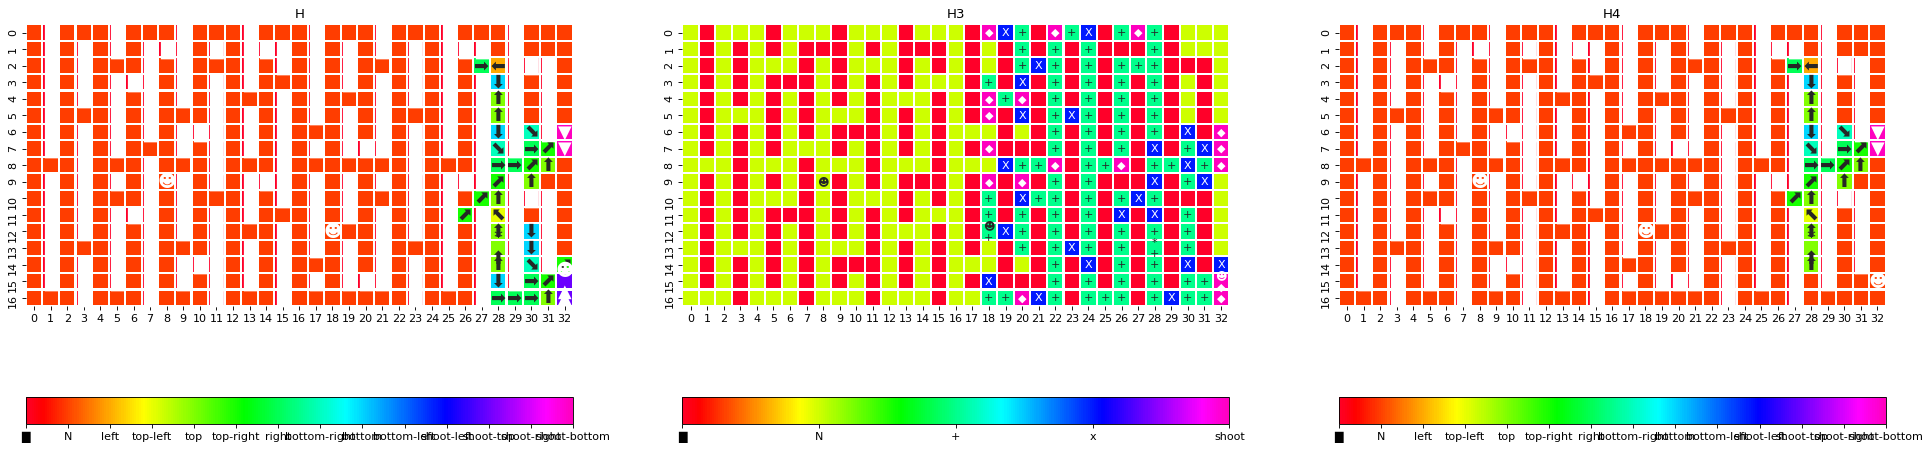

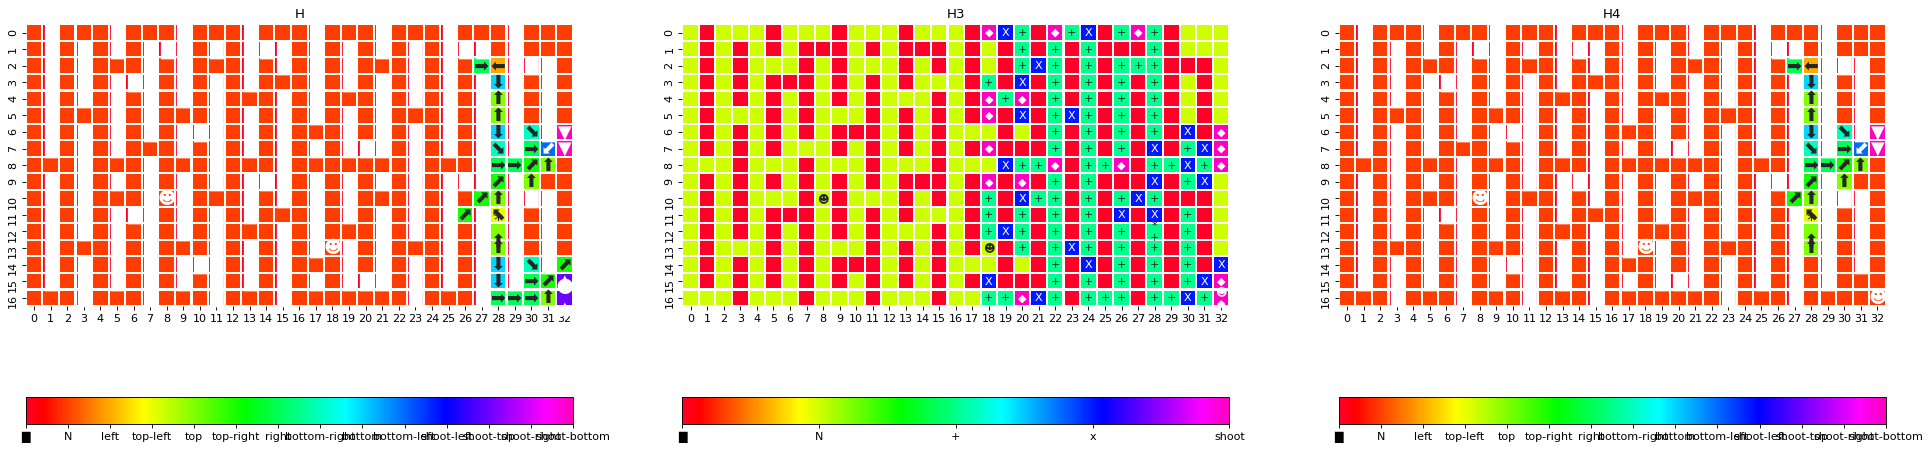

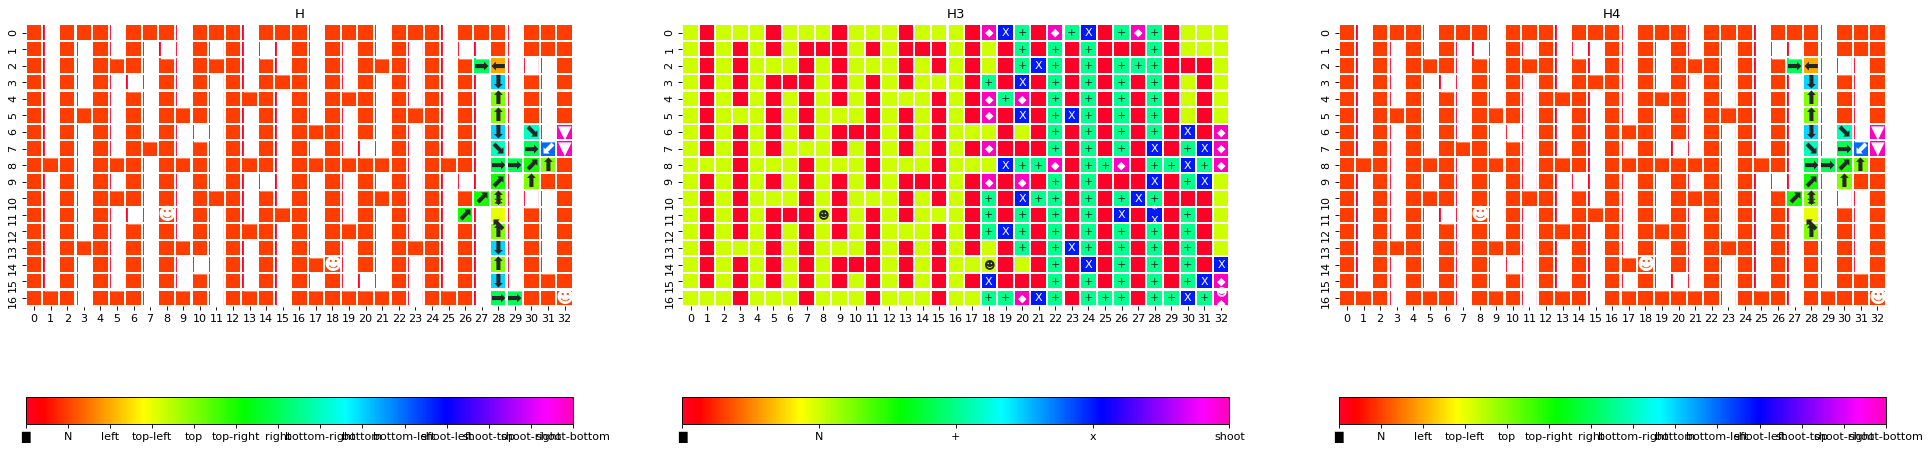

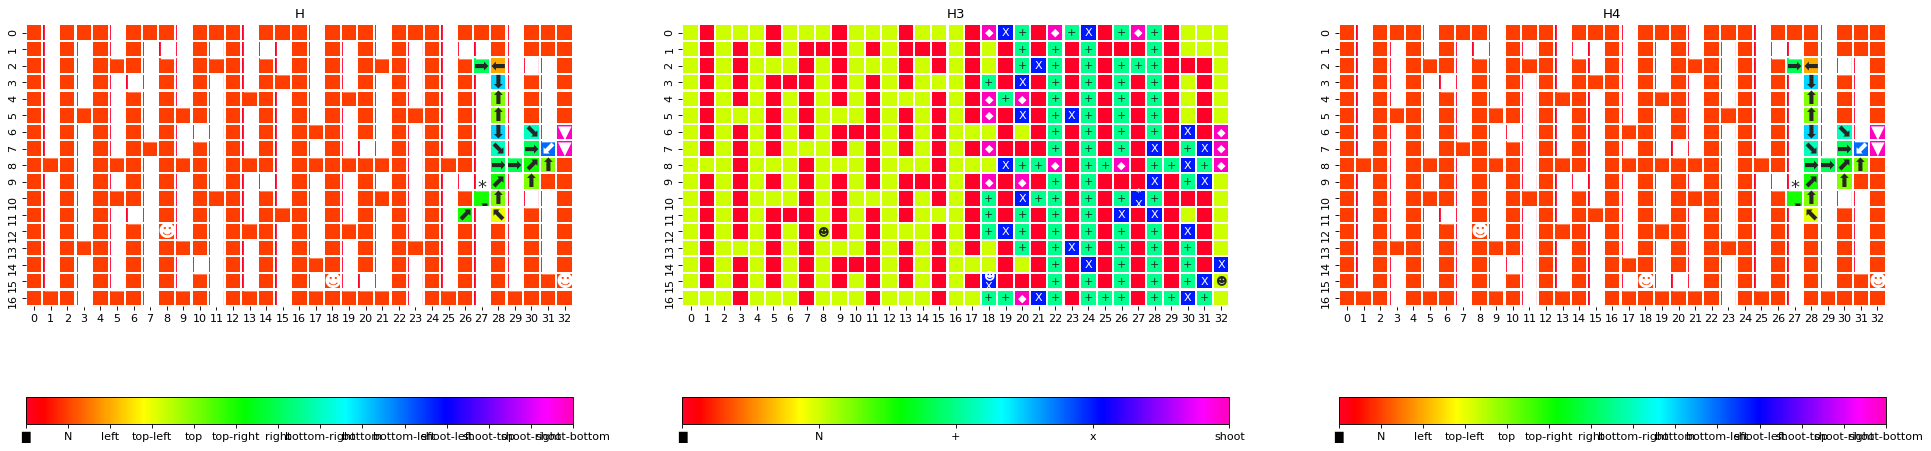

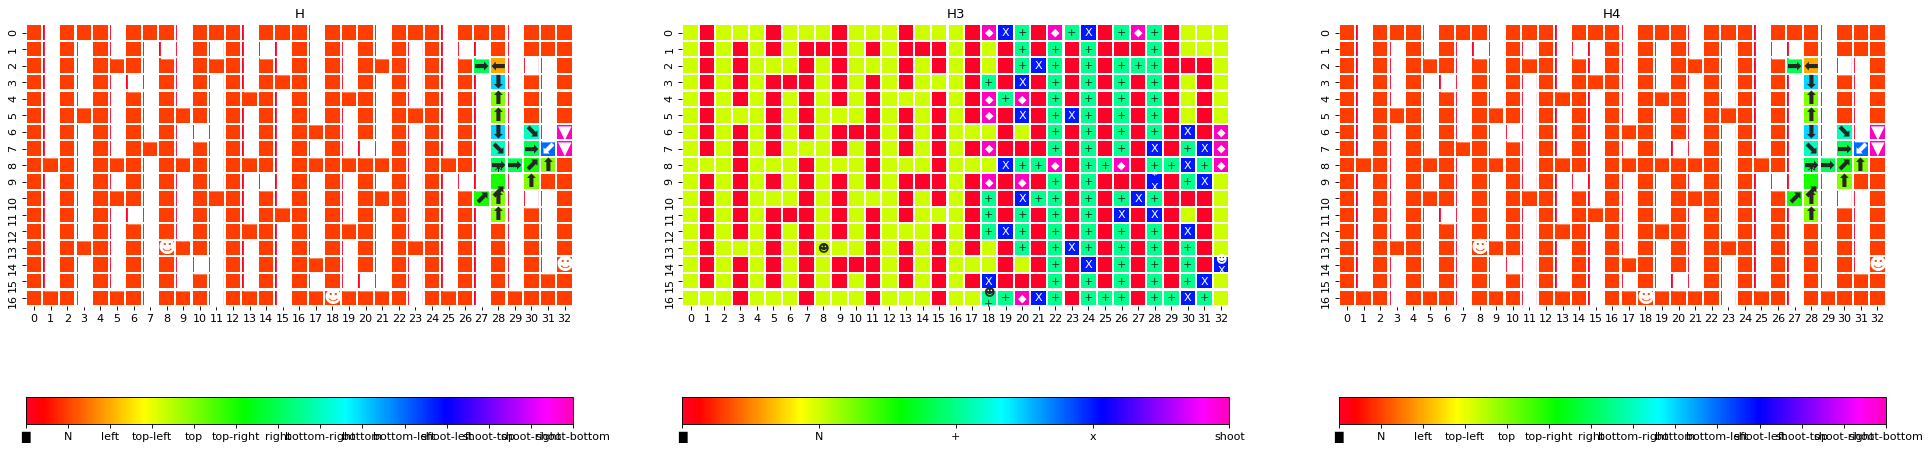

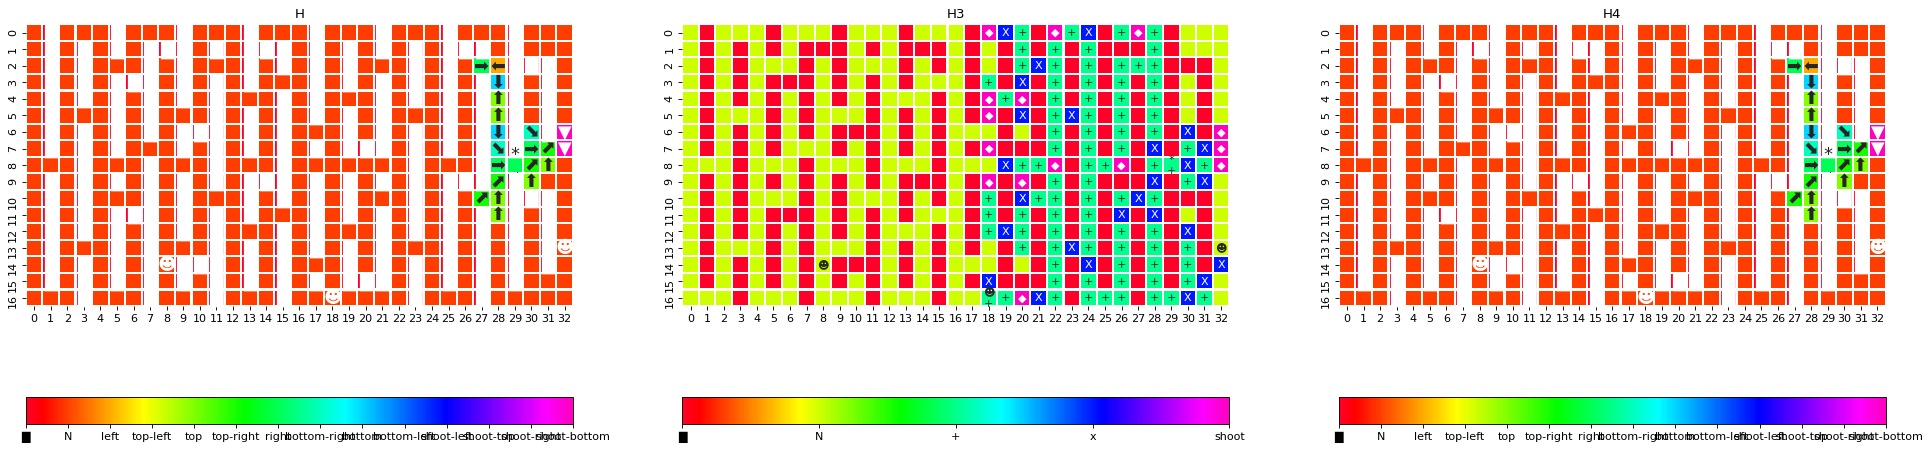

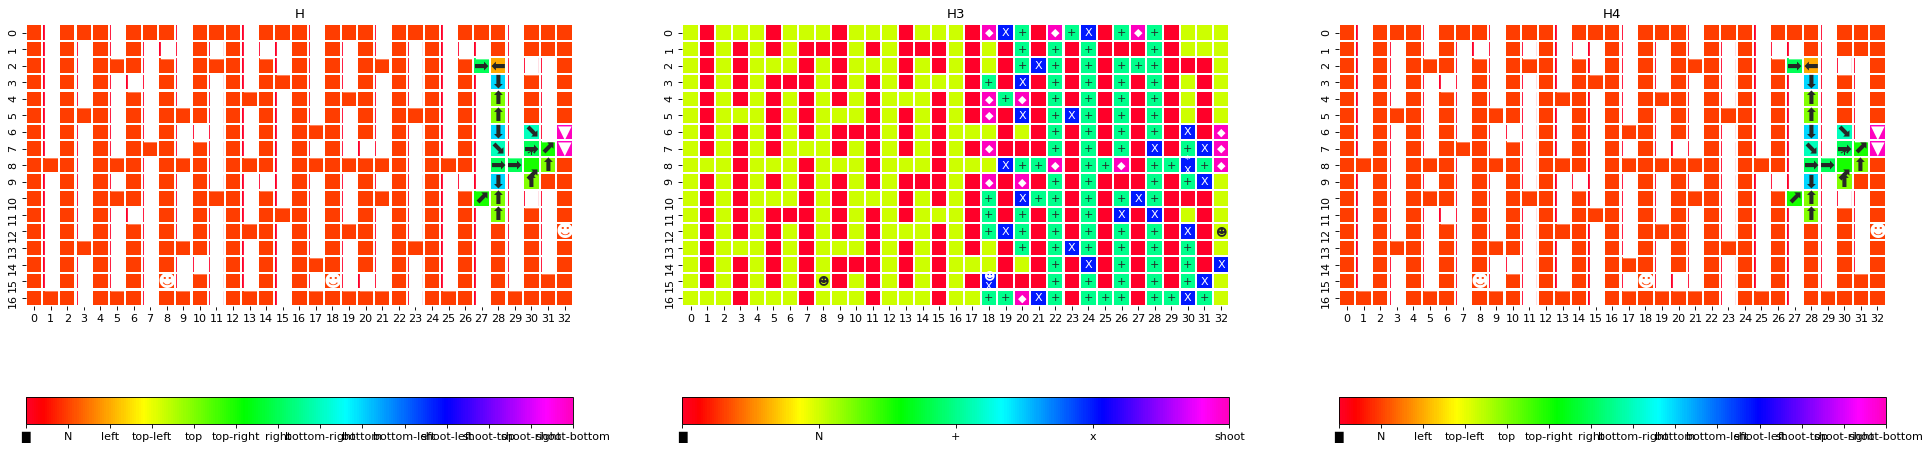

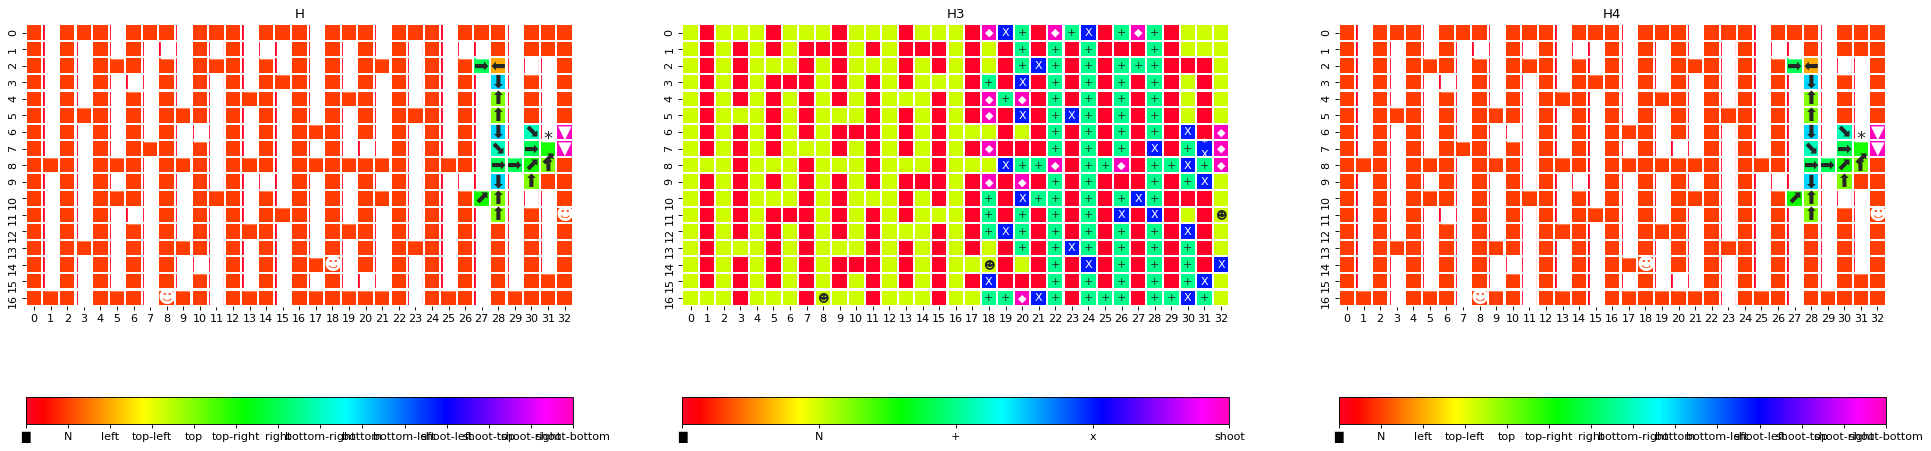

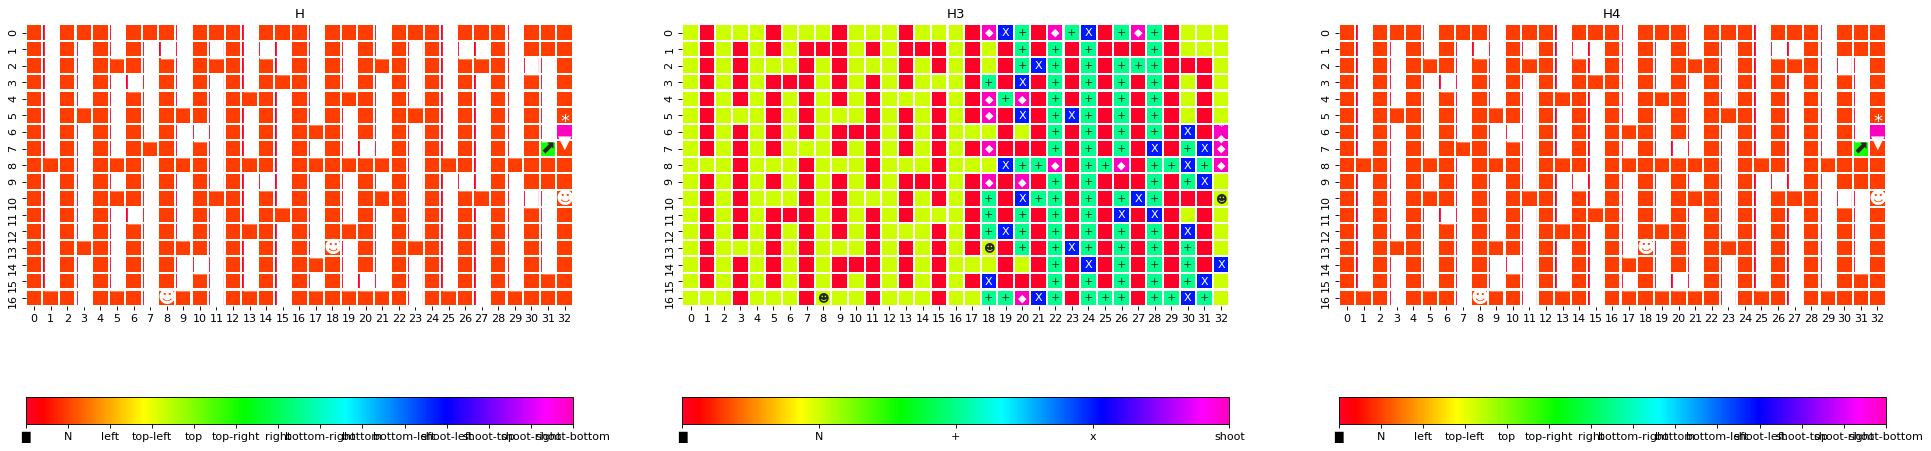

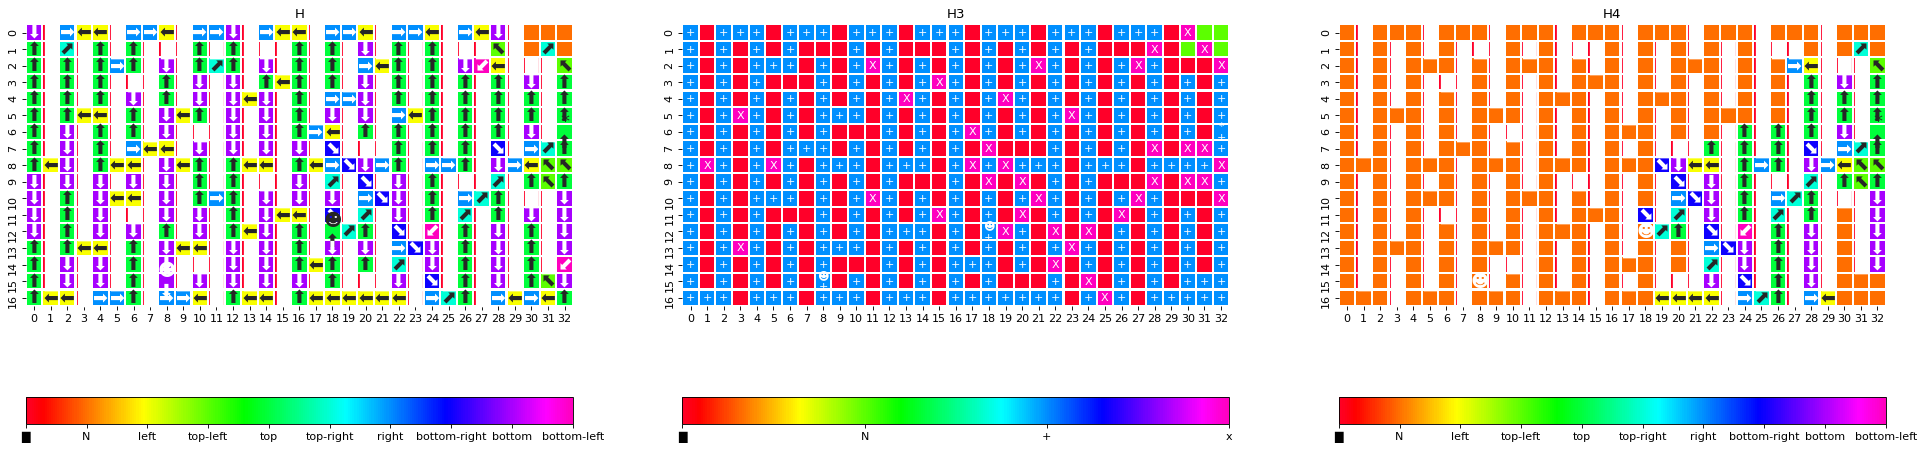

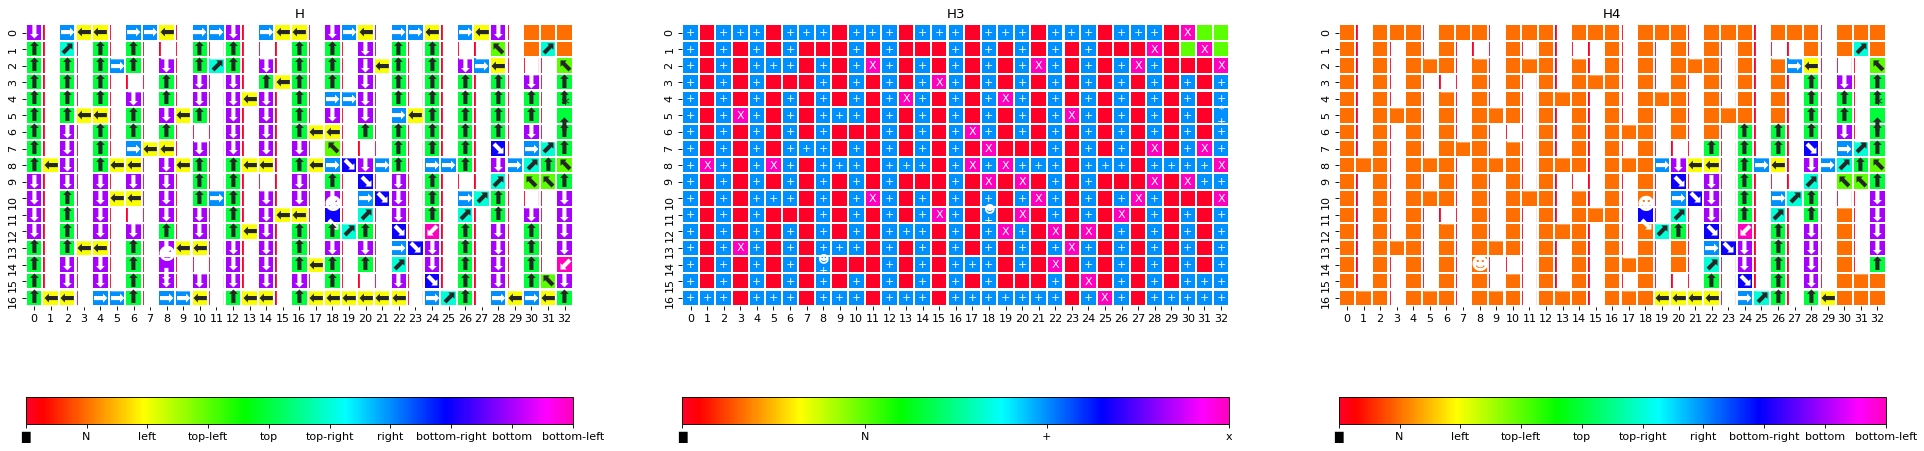

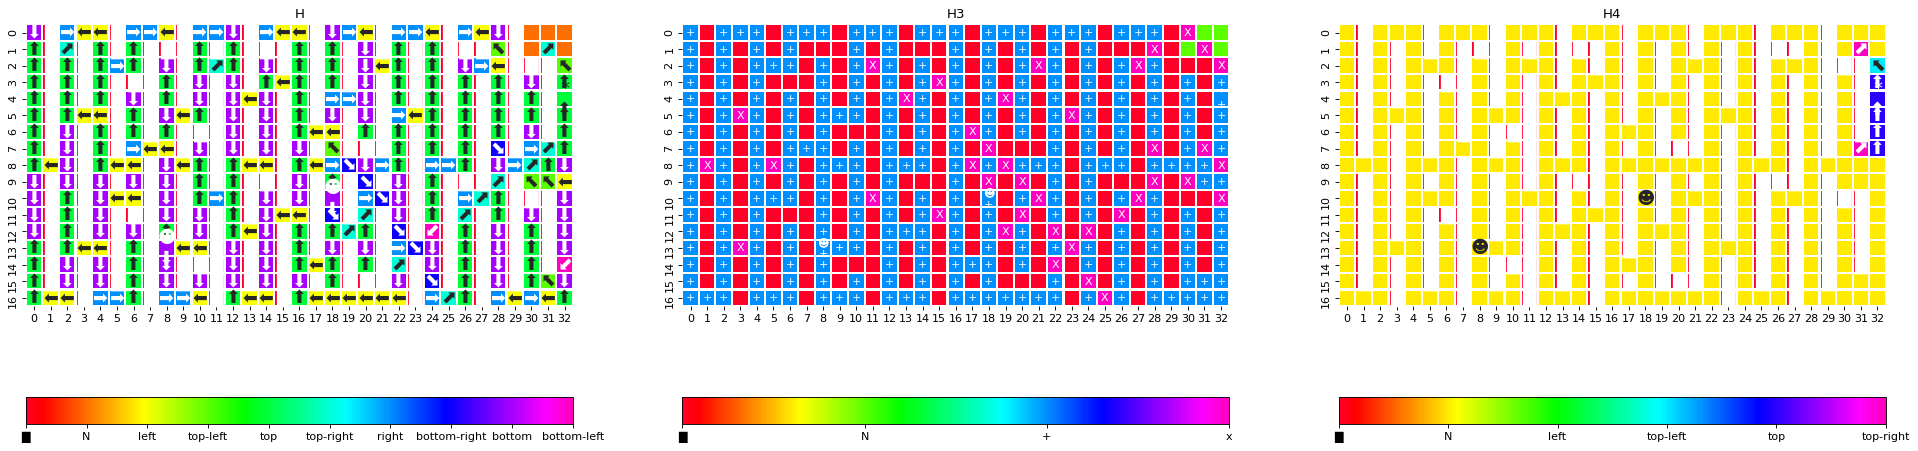

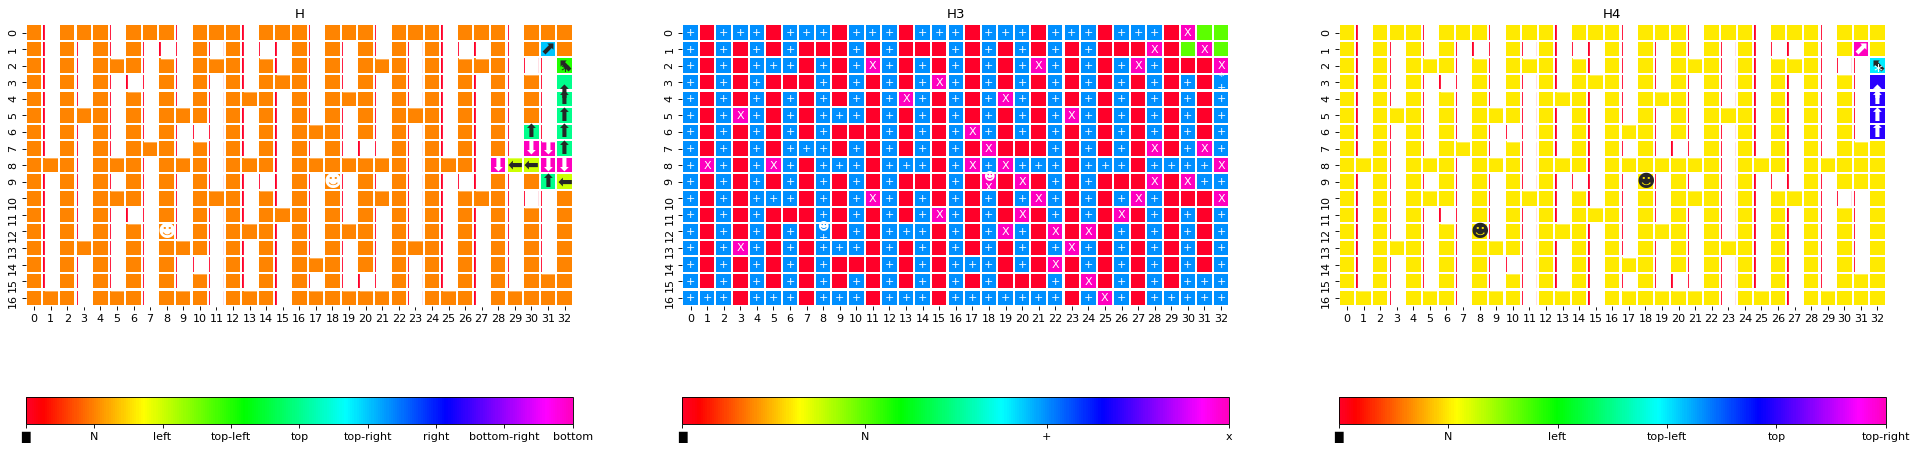

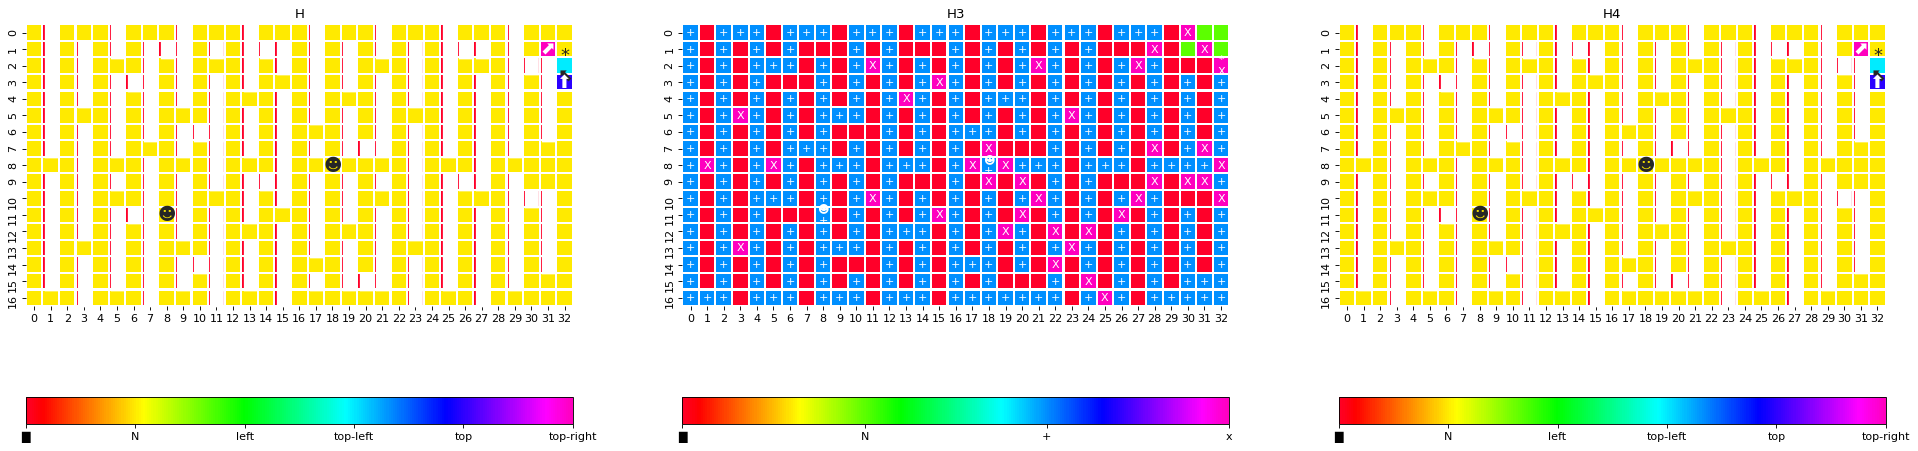

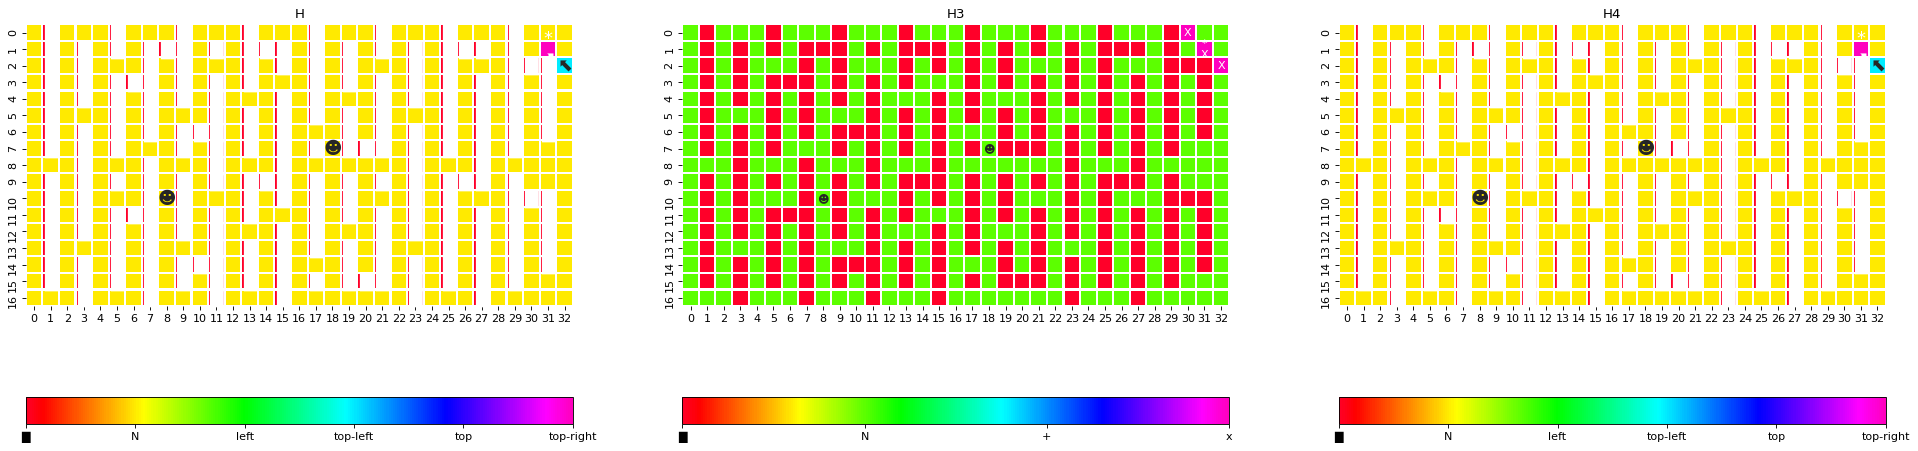

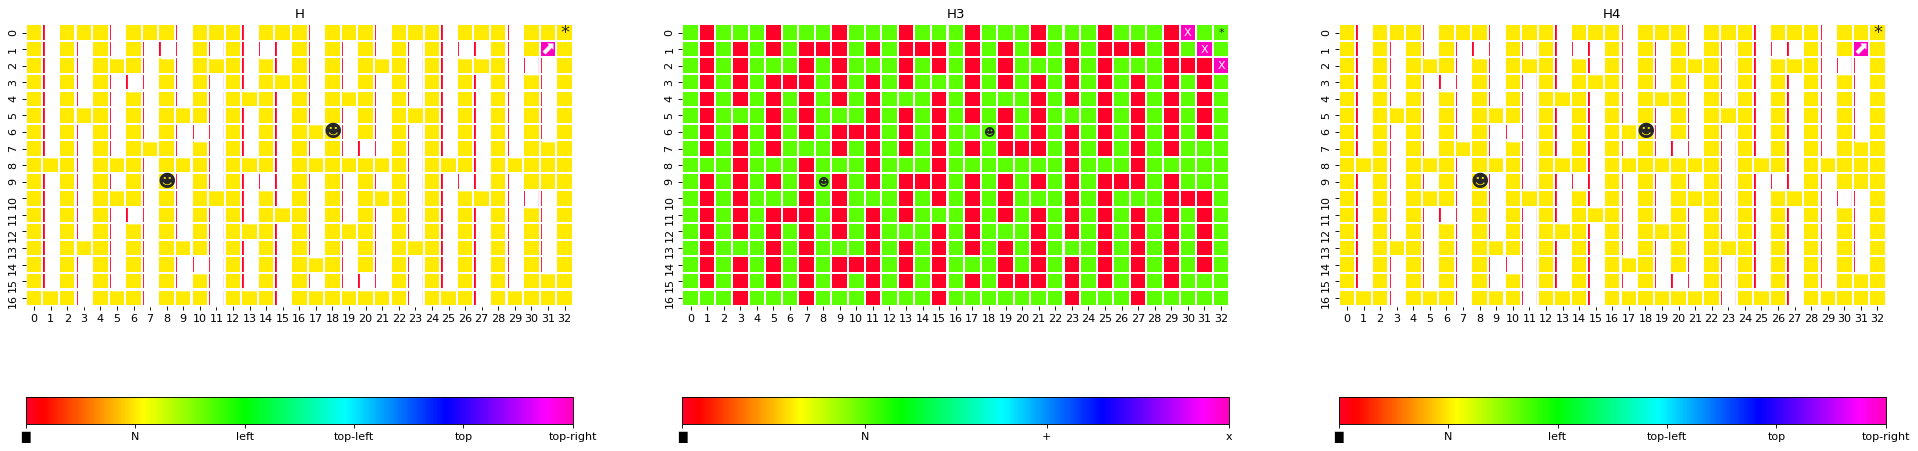

In [10]:
def testVideo(mEnv, initPos=None, filename = None, max = 100, plotFlag=False ):
    filename = filename + ".mp4"
    ["left", "top-left", "top", "top-right", "right", "bottom-right", "bottom", "bottom-left", "shoot-left", "shoot-top", "shoot-right", "shoot-bottom"]
    simbols = ["⬅", "⬉", "⬆", "⬈", "➡", "⬊", "⬇", "⬋", "◀", "▲", "▶", "▼"]
    simbols3 = ["+", "X", "◆"]
    with imageio.get_writer(filename, fps=30) as video:
      current_observation = mEnv.env.reset()
      if not all(initPos == None):
        mEnv.env.initPos = initPos
        mEnv.env.currentPos = initPos
        mEnv.env.__drawCurrentPos__()
        current_observation = mEnv.env.observation(initPos)
      video.append_data(mEnv.env.render(mode='rgb_array'))
      done = False
      actions = mEnv.env.action_name
      limit = 0
      while not done and limit < max:
        action = mEnv.policy(current_observation)
        action3 = mEnv._actionConverter[action]
        next_observation, reward, done, _info = mEnv.env.step(action)

        if plotFlag:
          print("state: ", current_observation, " action: ", action, " action3: ", action3, " action_n: ", actions[action], " Pos: ", mEnv.env.currentPos, " obs enemy:", mEnv.env.observation_enemy())
          data = np.reshape(mEnv._H[current_observation, action], (*mEnv.env._bins_env, 12))[:, : ,mEnv.env.observation_enemy(), :]
          data3 = np.reshape(mEnv._H3[current_observation, action3], (*mEnv.env._bins_env, 3))[:, : ,mEnv.env.observation_enemy(), :]
          data4 = np.reshape(mEnv._H4_t[current_observation, action], (*mEnv.env._bins_env, 12))[:, : ,mEnv.env.observation_enemy(), :]

          appDataH = np.zeros(data.shape[:-1])
          ll = np.empty(appDataH.shape, dtype="<U6")
          for i in range(len(data)):
            for j in range(len(data[i])):
              if (mEnv.env.mapStr[i][j] == '█'):
                appDataH[i][j] = -2
                ll[i][j] = "█"
              elif all(data[i][j] == 0.0):
                appDataH[i][j] = -1
                if (mEnv.env.mat[i][j] == '*'):
                  ll[i][j] = "*"
                elif (mEnv.env.mat[i][j] == '☻'):
                  ll[i][j] = "☻"
                else:
                  ll[i][j] = " "
              else:
                appDataH[i][j] = data[i][j].argmax()
                if (mEnv.env.mat[i][j] == '*'):
                  ll[i][j] = "*\n"+simbols[int(appDataH[i][j])]
                elif (mEnv.env.mat[i][j] == '☻'):
                  ll[i][j] = "☻\n"+simbols[int(appDataH[i][j])]
                else:
                  ll[i][j] = simbols[int(appDataH[i][j])]

          appDataH3 = np.zeros(data3.shape[:-1])
          ll3 = np.empty(appDataH3.shape, dtype="<U6")
          for i in range(len(data3)):
            for j in range(len(data3[i])):
              if (mEnv.env.mapStr[i][j] == '█'):
                appDataH3[i][j] = -2
                ll3[i][j] = " "
              elif all(data3[i][j] == 0.0):
                appDataH3[i][j] = -1
                if (mEnv.env.mat[i][j] == '*'):
                  ll3[i][j] = "*"
                elif (mEnv.env.mat[i][j] == '☻'):
                  ll3[i][j] = "☻"
                else:
                  ll3[i][j] = " "
              else:
                appDataH3[i][j] = data3[i][j].argmax()
                if (mEnv.env.mat[i][j] == '*'):
                  ll3[i][j] = "*\n"+simbols3[int(appDataH3[i][j])]
                elif (mEnv.env.mat[i][j] == '☻'):
                  ll3[i][j] = "☻\n"+simbols3[int(appDataH3[i][j])]
                else:
                  ll3[i][j] = simbols3[int(appDataH3[i][j])]

          appDataH4 = np.zeros(data4.shape[:-1])
          ll4 = np.empty(appDataH4.shape, dtype="<U6")
          for i in range(len(data4)):
            for j in range(len(data4[i])):
              if (mEnv.env.mapStr[i][j] == '█'):
                appDataH4[i][j] = -2
                ll4[i][j] = "█"
              elif all(data4[i][j] == 0.0) or all( data4[i][j][k] == data4[i][j][k+1] for k in range(len(data4[i][j])-1) ):
                appDataH4[i][j] = -1
                if (mEnv.env.mat[i][j] == '*'):
                  ll4[i][j] = "*"
                elif (mEnv.env.mat[i][j] == '☻'):
                  ll4[i][j] = "☻"
                else:
                  ll4[i][j] = " "
              else:
                appDataH4[i][j] = data4[i][j].argmax()
                if (mEnv.env.mat[i][j] == '*'):
                  ll4[i][j] = "*\n"+simbols[int(appDataH4[i][j])]
                elif (mEnv.env.mat[i][j] == '☻'):
                  ll4[i][j] = "☻\n"+simbols[int(appDataH4[i][j])]
                else:
                  ll4[i][j] = simbols[int(appDataH4[i][j])]

          f, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), dpi=80)
          ax[0].title.set_text("H")
          ax[0] = sns.heatmap(appDataH, cmap='gist_rainbow', linewidths=1.0, xticklabels=np.arange(data.shape[1]), yticklabels=np.arange(data.shape[0]), cbar=False, annot=ll, annot_kws={"fontsize":16}, fmt='', square=True, ax=ax[0], cbar_ax = ax[0])
          cbar1 = ax[0].figure.colorbar(ax[0].collections[0], orientation='horizontal', ax=ax[0])
          cbar1.set_ticks([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
          cbar1.set_ticklabels(["█", "N", *mEnv.env.action_name])

          ax[1].title.set_text("H3")
          ax[1] = sns.heatmap(appDataH3, cmap='gist_rainbow', linewidths=1.0, xticklabels=np.arange(data.shape[1]), yticklabels=np.arange(data.shape[0]), cbar=False, annot=ll3, fmt='', square=True, ax=ax[1], cbar_ax = ax[1], cbar_kws={"orientation": "horizontal"})
          cbar1 = ax[1].figure.colorbar(ax[1].collections[0], orientation='horizontal', ax=ax[1])
          cbar1.set_ticks([-2, -1, 0, 1, 2])
          cbar1.set_ticklabels(["█", "N", "+", "x", "shoot"])

          ax[2].title.set_text("H4")
          ax[2] = sns.heatmap(appDataH4, cmap='gist_rainbow', linewidths=1.0, xticklabels=np.arange(data4.shape[1]), yticklabels=np.arange(data4.shape[0]), cbar=False, annot=ll4, annot_kws={"fontsize":16}, fmt='', square=True, ax=ax[2], cbar_ax = ax[2])
          cbar1 = ax[2].figure.colorbar(ax[2].collections[0], orientation='horizontal', ax=ax[2])
          cbar1.set_ticks([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
          cbar1.set_ticklabels(["█", "N", *mEnv.env.action_name])
          plt.plot()

        current_observation = next_observation

        video.append_data(mEnv.env.render(mode='rgb_array'))
        limit += 1
    def embed_mp4(filename):
      """Embeds an mp4 file in the notebook."""
      video = open(filename,'rb').read()
      b64 = base64.b64encode(video)
      tag = '''
      <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
      Your browser does not support the video tag.
      </video>'''.format(b64.decode())

      return IPython.display.HTML(tag)
    return embed_mp4(filename)
initPos=np.array([16, 30])
#initPos=np.array([None, None])
testVideo(mEnv, initPos=initPos, filename = "QCarPole", max = 20, plotFlag=True)

##Test on Q CarPole

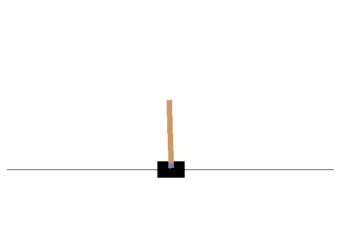

In [8]:
# Current enviroment
env = gym.make("CartPole-v1")
env.reset()
plt.axis('off')
plt.imshow(env.render(mode='rgb_array'));

###Class

In [21]:
class CarpoleEnv(ObservationWrapper):
  def __init__(self, env, bins, α, γ, ε_init_value, ε_final_value, ε_tot_epochs, low, high, Kq):
    super().__init__(env)

    # Number of bins per feature
    self._bins = bins

    self._α = α # Learning rate
    self._γ = γ # Discount factor

    # Exploration
    self._ε_init_value = ε_init_value
    self._ε_final_value = ε_final_value
    self._ε_tot_epochs = ε_tot_epochs
    
    # Arrays to save execution times and rewards during training
    self.times = []
    self.rewards = []

    # Discretization of the observation space
    self.observation_space = Discrete(np.prod(self._bins))

    # Object to bin continuous data into intervals
    self._bins_discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    self._bins_discretizer.fit([low, high])

    # Q table and H table
    self._Q = np.zeros(shape=(self.observation_space.n, self.action_space.n))
    self._H = defaultdict(lambda: np.zeros(shape=self._Q.shape))

    self.Kq = Kq # Important of expected_reward
    self._H4_t = defaultdict(lambda: np.zeros(shape=self._Q.shape))

  # Return the index of the table that correspond to this observation
  def fromObsToNum(self, observation):
    return sum([observation[-(i+1)] if i == 0 else reduce(lambda x, y: x*y, self._bins[-i:]) * observation[-(i+1)] for i in reversed(range(len(self._bins))) ])

  # Discretize the observation into the bins
  def discretizer(self, car_position, car_velocity, pole_angle, pole_velocity):
    return tuple(map(int, self._bins_discretizer.transform([[car_position, car_velocity, pole_angle, pole_velocity]])[0] ))

  # Overriding the method observation in order to return the discretized observation
  def observation(self, observation):
    return self.fromObsToNum(self.discretizer(*observation))

  # return the next action to do based on the current observation
  def policy(self, current_observation):
    return np.argmax(self._Q[current_observation])

  # Return the value of the exploration time based on the current epoch in a linear way
  def explorationValue(self, epoch):
    epochs_progress = epoch/self._ε_tot_epochs
    if epochs_progress > 1:
      return self._ε_final_value
    return self._ε_init_value + epochs_progress * (self._ε_final_value - self._ε_init_value)

  # return the time between 2 intervals
  def elapsedTime(self, start):
    done = time.time()
    elapsed = done - start
    self.times.append(elapsed)
    return elapsed
  
  # Saves the Q and H table
  def save(self, path="./", name='values'):
    np.save(path+name+'_Q', self._Q, allow_pickle=True)
    np.savez(path+name+'_H', dict(self._H), allow_pickle=True)

  # Load the Q and H table
  def load(self, path="./", name='values'):
    self._Q[:] = np.load(path+name+'_Q.npy', allow_pickle=True)
    with np.load(path+name+'_H.npz', allow_pickle = True) as data:
            self._H.update(data['arr_0'].item())

  def train(self, tot_epochs_train, max_epoch_step, print_info=False, print_info_episodes=100):
    # inizialize data for time execution ad rewards
    start = time.time()
    epoch_reward = 0

    # starting main loop for training
    for epoch in range(1, tot_epochs_train+1):
      # inizialize data
      step = 0 # number of actions done in this epoch
      done = False # bool to check termination
      current_observation = self.reset() # starting the enviroment
      
      # do actions until the agent terminate or has done enough steps
      while not done and step < max_epoch_step:
        # the agent pick an action
        if np.random.random_sample() > self.explorationValue(epoch):
          # random action
          action = self.policy(current_observation)
        else:
          # action based on the policy
          action = self.action_space.sample()
        
        # Perform action
        next_observation, reward, done, _info = self.step(action)
        argmax_a = np.argmax(self._Q[next_observation])

        # Compute data to evaluate expected_reward and intent_update used to update Q and H
        expected_reward = reward + self._γ * np.max(self._Q[next_observation]) *\
            (1-int(done)) - self._Q[current_observation, action]
        intent_update = np.zeros(self._Q.shape)

        intent_update[current_observation, action] += 1
        expected_intent = intent_update + self._γ * self._H[next_observation, argmax_a] *\
            (1-int(done)) - self._H[current_observation, action]
        del intent_update
        
        # update Q and H
        self._Q[current_observation, action] += self._α * expected_reward
        self._H[current_observation, action] = self._H[current_observation, action] +\
            self._α * expected_intent
        del expected_intent
        
        # Compute data to evaluate intent_update4 and expected_intent4 used to update H4
        intent_update4 = np.zeros(self._Q.shape)
        intent_update4[current_observation, action] += 1
        expected_intent4 = intent_update4 + self._γ * self._H4_t[next_observation, argmax_a]*(1-int(done)) -\
            self._H4_t[current_observation, action]
        del intent_update4

        # update H4
        #
        # in this case we used also the expected_reward to evaluate H4
        self._H4_t[current_observation, action] += self._α * expected_intent4 + self.Kq * expected_reward
        del expected_intent4

        # update data for the loop
        current_observation = next_observation
        step += 1
        epoch_reward += reward
      
      # Print informations for the training
      if print_info and (epoch) % print_info_episodes == 0:
        avgReward = epoch_reward/print_info_episodes
        epoch_reward = 0
        self.rewards.append(avgReward)
        print("Episode %d, reward: %f,  time: %f s" %(epoch, avgReward, self.elapsedTime(start)))
        start = time.time()
        
      self.close()
    self.close()

  # Function used to test the trained agent
  def test(self, filename, max = 20):
    # create a new File video
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=30) as video:
      # Restart the enviroment
      current_observation = self.reset()
      # add the current state of the enviroment
      video.append_data(self.render(mode='rgb_array'))
      # init data for the loop
      done = False
      limit = 0
      while not done and limit < max:
        # takes an action based on the policy
        action = self.policy(current_observation)
        # perform action
        next_observation, reward, done, _info = self.step(action)

        # plot data to show the data in H
        print("step: ", limit)
        print("current_observation: ", current_observation)
        print("action: ", action)
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=80)
        ax[0].title.set_text("H[("+ str(current_observation) +", "+ str(action) +")]")
        ax[0].plot(self._H[current_observation, action])
        ax[1].title.set_text("H4[("+ str(current_observation) +", "+ str(action) +")]")
        ax[1].plot(self._H4_t[current_observation, action])
        plt.show()

        current_observation = next_observation
        # add the current state of the enviroment
        video.append_data(self.render(mode='rgb_array'))
        limit += 1
    self.close()
    def embed_mp4(filename):
      """Embeds an mp4 file in the notebook."""
      video = open(filename,'rb').read()
      b64 = base64.b64encode(video)
      tag = '''
      <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
      Your browser does not support the video tag.
      </video>'''.format(b64.decode())

      return IPython.display.HTML(tag)
    return embed_mp4(filename)

###Test

learning rate α = 0.1 and discount factor γ = 1

Episode terminates when the length of the episode reaches 200 timestep

We initially set exploration probability ε = 1 which is linearly decreased to ε = 0.1 throughout the first 500 episodes

In [22]:
env = gym.make('CartPole-v1') # enviroment

bins=np.array([3, 3, 6, 3]) # bins to subdivide the observation state [car_position, car_velocity, pole_angle, pole_velocity]

α = 0.1 # learning rate
γ = 1.0 # discount factor

ε_init_value = 1 # exploration probability
ε_final_value = 0.1 # final exploration value
ε_tot_epochs = 500 # number of epochs decay

Kq = 0.01 # Important of expected_reward

low = np.array([-2.4, -2.5, -np.radians(12), -1]) # Observation space min value
high = np.array([2.4, 2.5, np.radians(12), 1]) # Observation space max value

mEnv = CarpoleEnv(env, bins, α, γ, ε_init_value, ε_final_value, ε_tot_epochs, low, high, Kq) # create the enviroment

Episode 10, reward: 22.300000,  time: 0.073677 s
Episode 20, reward: 24.700000,  time: 0.066296 s
Episode 30, reward: 29.900000,  time: 0.084090 s
Episode 40, reward: 30.500000,  time: 0.090713 s
Episode 50, reward: 23.300000,  time: 0.069318 s
Episode 60, reward: 23.700000,  time: 0.066928 s
Episode 70, reward: 16.300000,  time: 0.046147 s
Episode 80, reward: 25.200000,  time: 0.074996 s
Episode 90, reward: 26.400000,  time: 0.086112 s
Episode 100, reward: 21.700000,  time: 0.062737 s
Episode 110, reward: 26.400000,  time: 0.074874 s
Episode 120, reward: 27.800000,  time: 0.075553 s
Episode 130, reward: 30.300000,  time: 0.083730 s
Episode 140, reward: 22.700000,  time: 0.065457 s
Episode 150, reward: 39.400000,  time: 0.101289 s
Episode 160, reward: 28.300000,  time: 0.086655 s
Episode 170, reward: 33.700000,  time: 0.114958 s
Episode 180, reward: 32.100000,  time: 0.091005 s
Episode 190, reward: 30.300000,  time: 0.078756 s
Episode 200, reward: 50.100000,  time: 0.144258 s
Episode 2

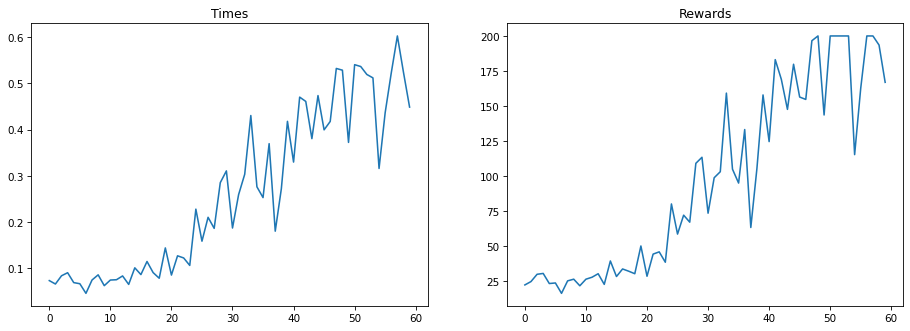

In [23]:
tot_epochs_train= 600 # number fo epochs
max_epoch_step=200 # number of steps to terminate an epoch

# train the agent
mEnv.train(tot_epochs_train, max_epoch_step, print_info=True, print_info_episodes=10)

# plot time exection and rewards over time
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=75)
ax[0].title.set_text("Times")
ax[0].plot(mEnv.times)
ax[1].title.set_text("Rewards")
ax[1].plot(mEnv.rewards)
plt.show()

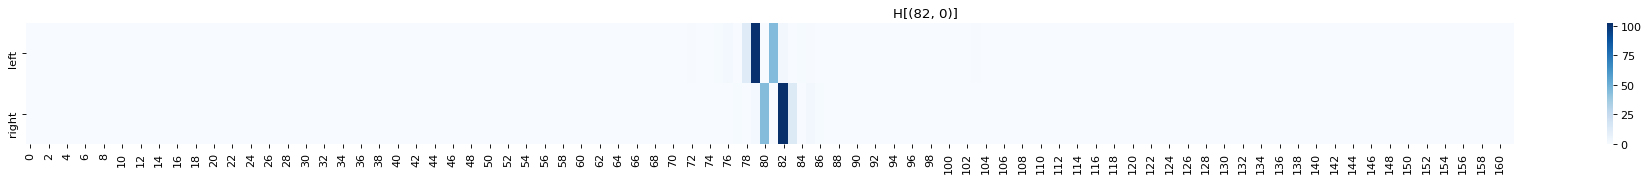

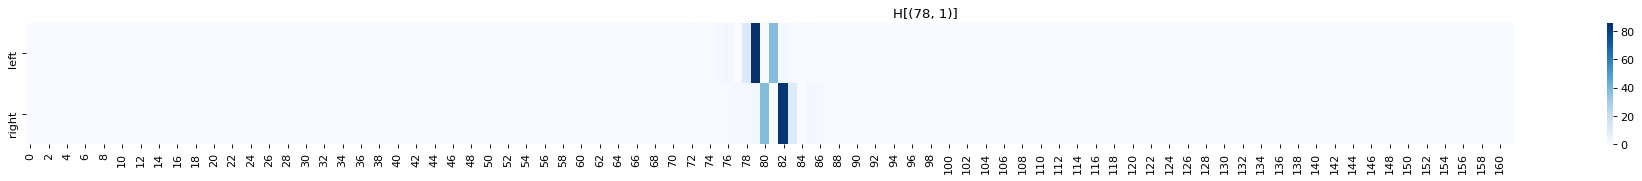

In [24]:
fig = plt.figure(figsize=(30, 2), dpi=80, )
fig.suptitle("H[(82, 0)]")
sns.heatmap(np.transpose(mEnv._H[(82, 0)]), cmap='Blues', linewidths=.0, xticklabels=2, yticklabels=['left', 'right'], square=False)#True)
plt.show()

fig = plt.figure(figsize=(30, 2), dpi=80, )
fig.suptitle("H[(78, 1)]")
sns.heatmap(np.transpose(mEnv._H[(78, 1)]), cmap='Blues', linewidths=.0, xticklabels=2, yticklabels=['left', 'right'], square=False)#True)
plt.show()

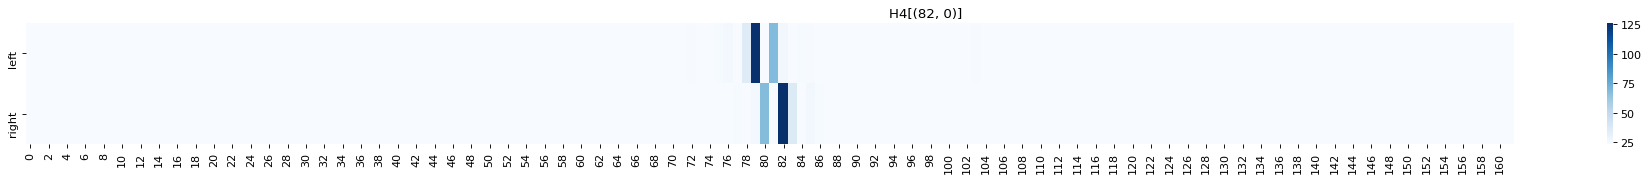

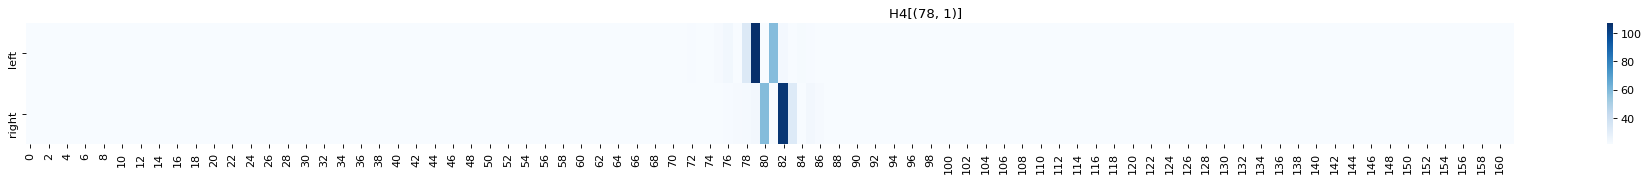

In [25]:
fig = plt.figure(figsize=(30, 2), dpi=80, )
fig.suptitle("H4[(82, 0)]")
sns.heatmap(np.transpose(mEnv._H4_t[(82, 0)]), cmap='Blues', linewidths=.0, xticklabels=2, yticklabels=['left', 'right'], square=False)#True)
plt.show()

fig = plt.figure(figsize=(30, 2), dpi=80, )
fig.suptitle("H4[(78, 1)]")
sns.heatmap(np.transpose(mEnv._H4_t[(78, 1)]), cmap='Blues', linewidths=.0, xticklabels=2, yticklabels=['left', 'right'], square=False)#True)
plt.show()

step:  0
current_observation:  79
action:  0


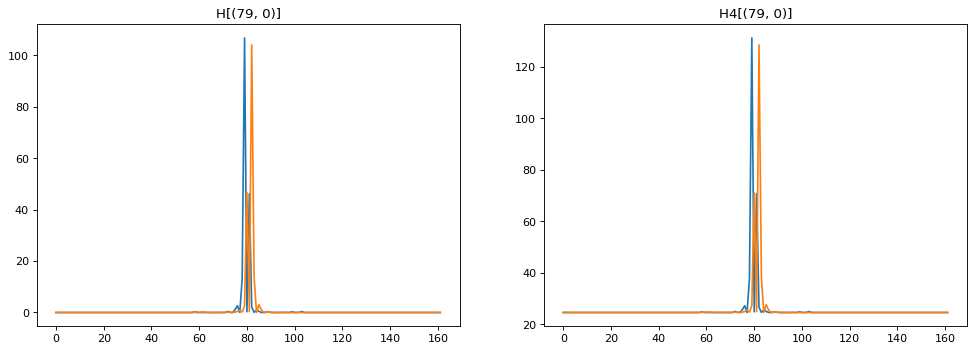

step:  1
current_observation:  79
action:  0


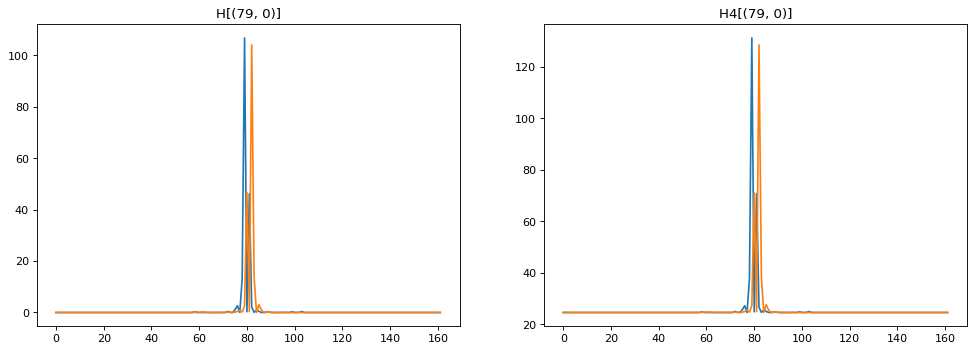

step:  2
current_observation:  80
action:  1


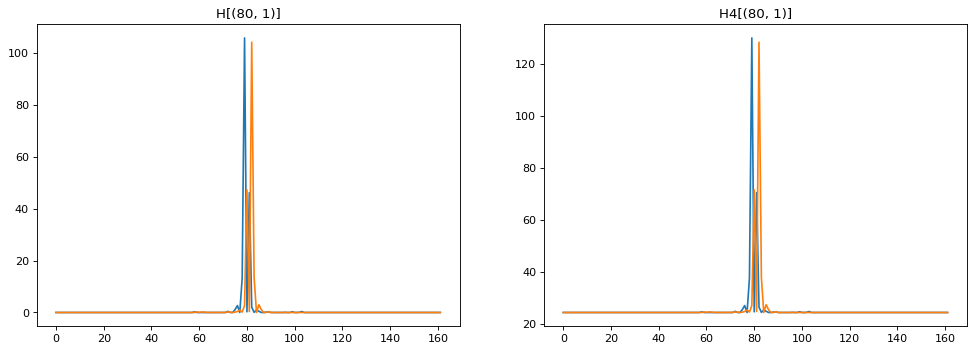

step:  3
current_observation:  79
action:  0


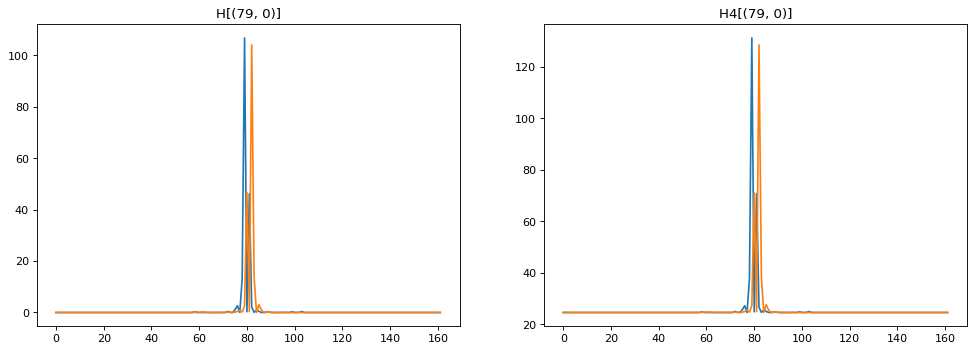

step:  4
current_observation:  80
action:  1


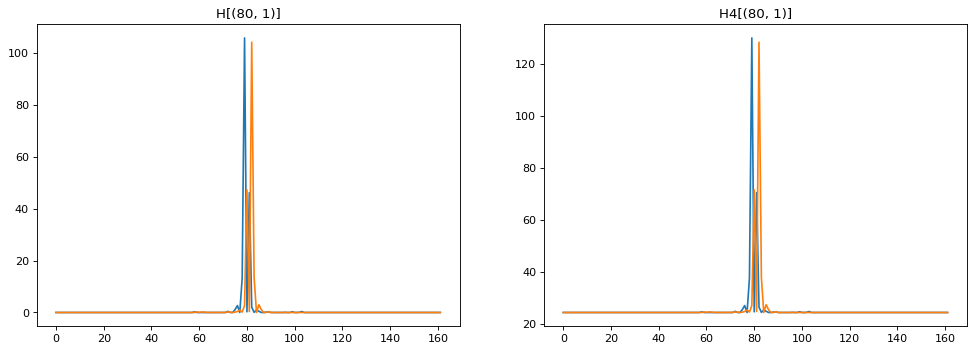

step:  5
current_observation:  82
action:  1


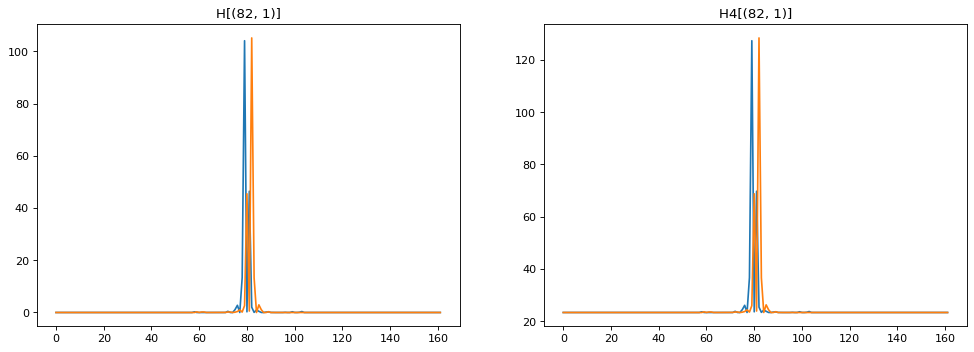

step:  6
current_observation:  82
action:  1


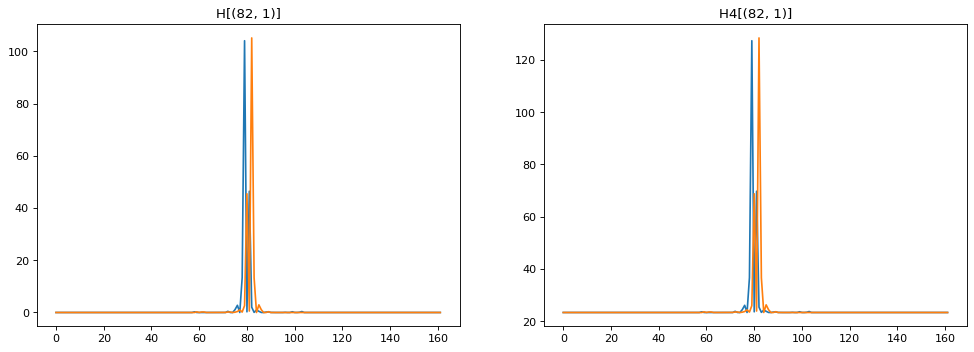

step:  7
current_observation:  82
action:  1


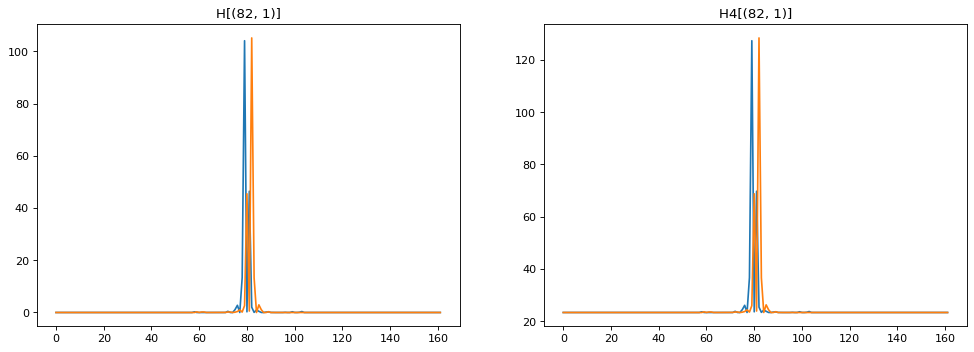

step:  8
current_observation:  81
action:  0


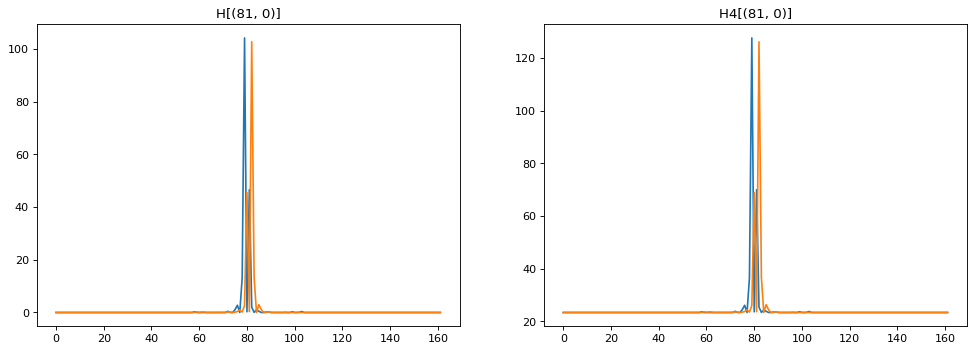

step:  9
current_observation:  79
action:  0


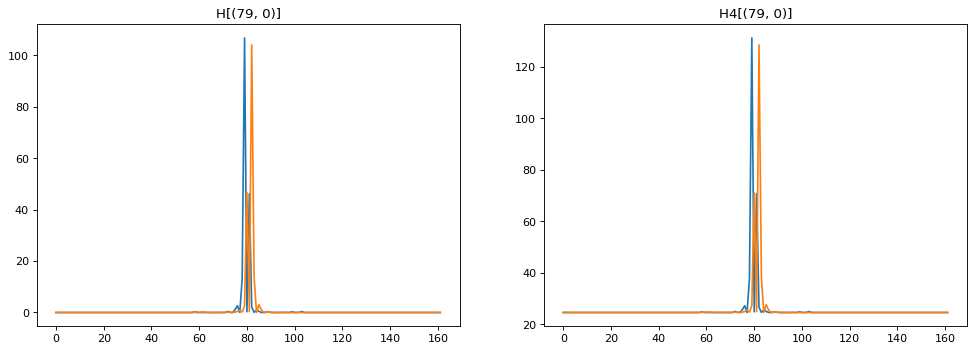

step:  10
current_observation:  79
action:  0


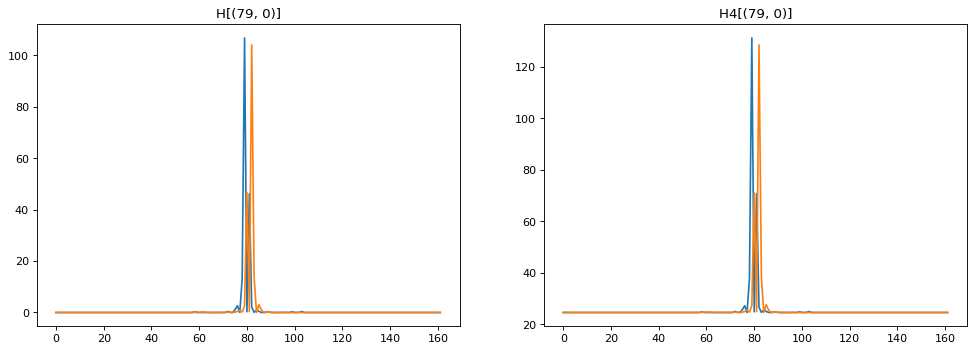

step:  11
current_observation:  79
action:  0


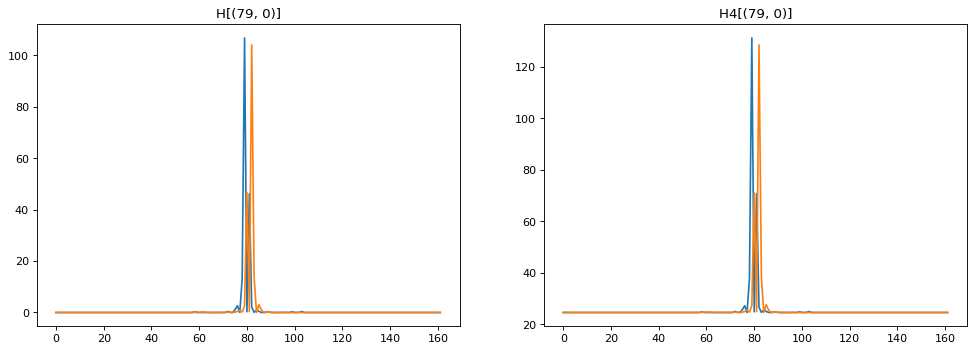

step:  12
current_observation:  83
action:  1


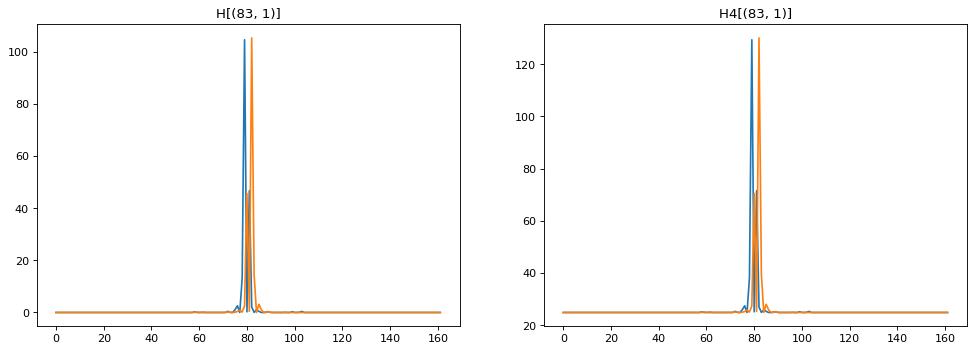

step:  13
current_observation:  82
action:  1


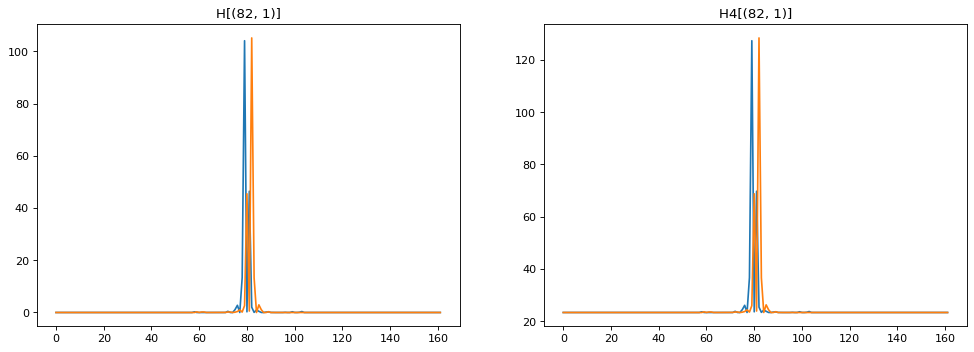

step:  14
current_observation:  82
action:  1


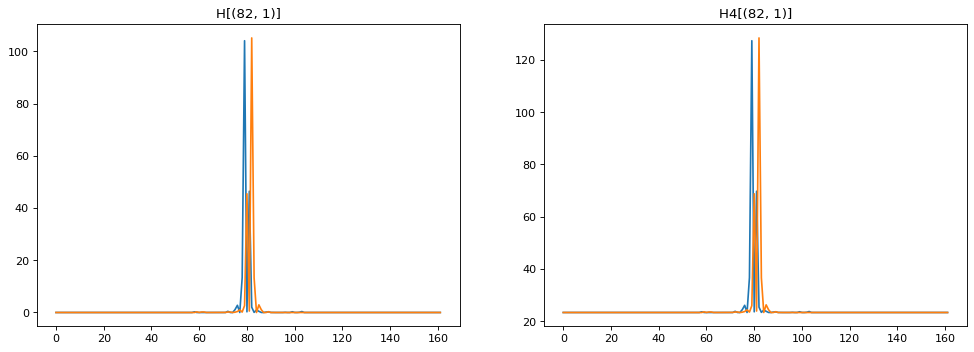

step:  15
current_observation:  82
action:  1


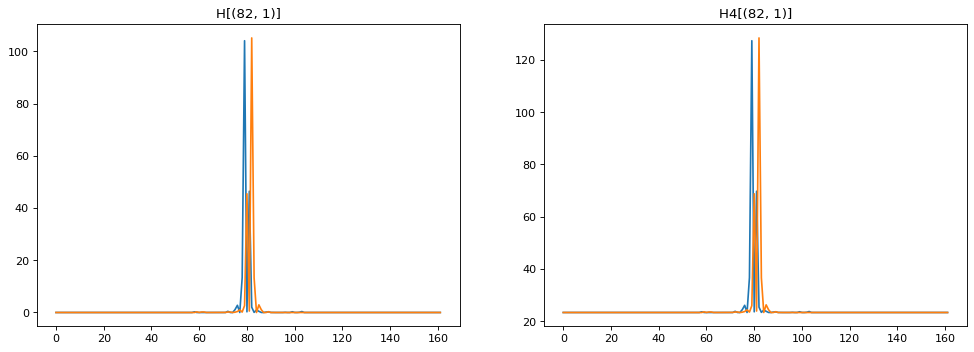

step:  16
current_observation:  81
action:  0


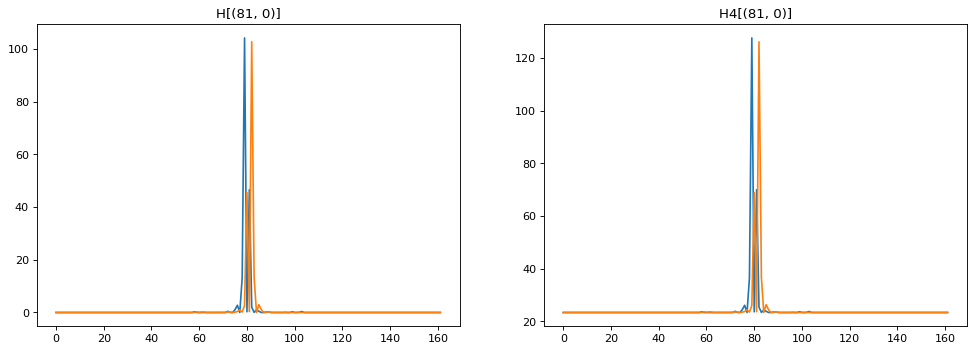

step:  17
current_observation:  82
action:  1


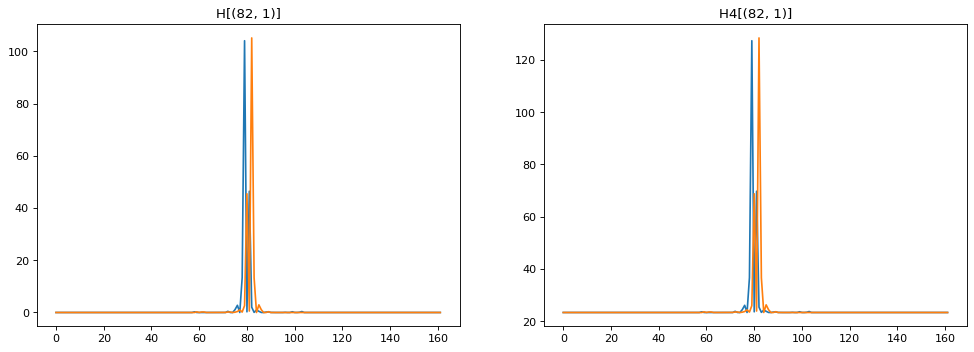

step:  18
current_observation:  78
action:  0


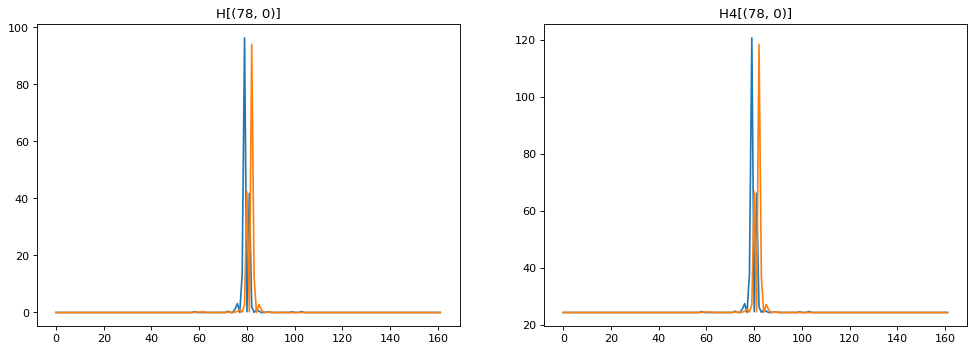

step:  19
current_observation:  79
action:  0


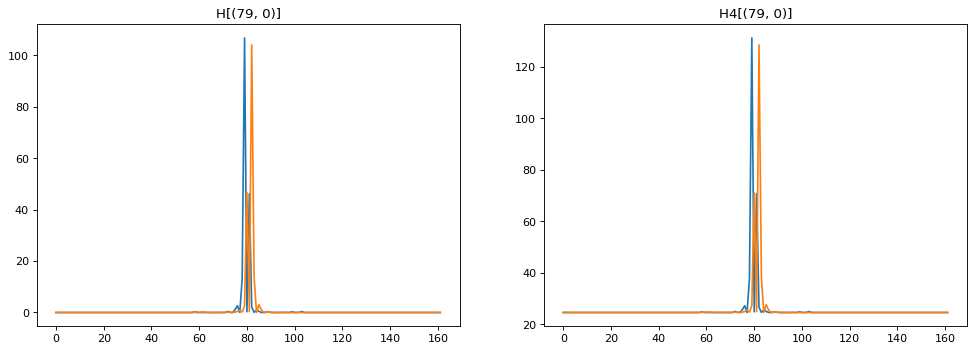

In [26]:
mEnv.test("QCarPole") # test the agent

##Test on Q Taxi

In [37]:
# Current enviroment
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



###Class

In [33]:
class TaxiEnv(ObservationWrapper):
  def __init__(self, env, α, γ, ε_init_value, ε_final_value, ε_tot_epochs, Kq):
    super().__init__(env)

    self._α = α # Learning rate
    self._γ = γ # Discount factor

    # Exploration
    self._ε_init_value = ε_init_value
    self._ε_final_value = ε_final_value
    self._ε_tot_epochs = ε_tot_epochs

    # Q table and H table
    self._Q = np.zeros((env.observation_space.n, env.action_space.n))
    self._H = defaultdict(lambda: np.zeros(shape=self._Q.shape))

    self.Kq = Kq # Important of expected_reward
    self._H4_t = defaultdict(lambda: np.zeros(shape=self._Q.shape))
    
    # Arrays to save execution times and rewards during training
    self.times = []
    self.rewards = []

  # Overriding the method observation
  def observation(self, observation):
    return observation

  # return the next action to do based on the current observation
  def policy(self, state_action):
    return np.argmax(self._Q[state_action])
  
  # Return the value of the exploration time based on the current epoch in a linear way
  def explorationValue(self, epoch):
    epochs_progress = epoch/self._ε_tot_epochs
    if epochs_progress > 1:
      return self._ε_final_value
    return self._ε_init_value + epochs_progress * (self._ε_final_value - self._ε_init_value)

  # return the time between 2 intervals
  def elapsedTime(self, start):
    done = time.time()
    elapsed = done - start
    self.times.append(elapsed)
    return elapsed
  
  # Saves the Q and H table
  def save(self, path="./", name='values'):
    np.save(path+name+'_Q', self._Q, allow_pickle=True)
    np.savez(path+name+'_H', dict(self._H), allow_pickle=True)

  # Load the Q and H table
  def load(self, path="./", name='values'):
    self._Q[:] = np.load(path+name+'_Q.npy', allow_pickle=True)
    with np.load(path+name+'_H.npz', allow_pickle = True) as data:
            self._H.update(data['arr_0'].item())
    
  def train(self, tot_epochs_train, max_epoch_step, print_info=False, print_info_episodes=100):
    # inizialize data for time execution ad rewards
    start = time.time()
    epoch_reward = 0

    # starting main loop for training
    for epoch in range(1, tot_epochs_train+1):
      # inizialize data
      step = 0 # number of actions done in this epoch
      done = False # bool to check termination
      current_observation = self.reset() # starting the enviroment
      
      # do actions until the agent terminate or has done enough steps
      while not done and step < max_epoch_step:
        # the agent pick an action
        if np.random.random_sample() > self.explorationValue(epoch):
          # random action
          action = self.policy(current_observation)
        else:
          # action based on the policy
          action = self.action_space.sample()
        
        # Perform action
        next_observation, reward, done, _info = self.step(action)
        argmax_a = np.argmax(self._Q[next_observation])

        # Compute data to evaluate expected_reward and intent_update used to update Q and H
        expected_reward = reward + self._γ * np.max(self._Q[next_observation]) *\
            (1-int(done)) - self._Q[(current_observation, action)]
        intent_update = np.zeros(self._Q.shape)
        intent_update[current_observation, action] += 1
        expected_intent = intent_update + self._γ * self._H[next_observation, argmax_a] *\
         (1-int(done)) - self._H[current_observation, action]
        del intent_update
        
        # update Q and H
        self._Q[(current_observation, action)] += self._α * expected_reward
        self._H[current_observation, action] = self._H[current_observation, action] +\
         self._α * expected_intent
        del expected_intent

        # Compute data to evaluate intent_update4 and expected_intent4 used to update H4
        intent_update4 = np.zeros(self._Q.shape)
        intent_update4[current_observation, action] += 1
        expected_intent4 = intent_update4 + self._γ * self._H4_t[next_observation, argmax_a]*(1-int(done)) -\
            self._H4_t[current_observation, action]
        del intent_update4

        # update H4
        #
        # in this case we used also the expected_reward to evaluate H4
        self._H4_t[current_observation, action] += self._α * expected_intent4 + self.Kq * expected_reward
        del expected_intent4
        
        # update data for the loop
        current_observation = next_observation
        step += 1
        epoch_reward += reward
      
      # Print informations for the training
      if print_info and (epoch) % print_info_episodes == 0:
        avgReward = epoch_reward/print_info_episodes
        epoch_reward = 0
        self.rewards.append(avgReward)
        print("Episode %d, reward: %f,  time: %f s" %(epoch, avgReward, self.elapsedTime(start)))
        start = time.time()
      
      self.close()
    self.close()

  # Function used to test the trained agent
  def test(self, max=50):
    # create a new Buffer
    frames = []
    # Restart the enviroment
    current_observation = self.reset()
    done = False
    limit = 0
    actions = ["down", "up", "right", "left", "pickup passenger", "drop off passenger"]
    sum_reward = 0

    # init data for the loop
    while not done and limit < max:
      # takes an action based on the policy
      action = self.policy(current_observation)
      # perform action
      next_observation, reward, done, _info = self.step(action)

      print("step: ", limit)
      print("current_observation: ", current_observation)
      print("action: ", action)
      f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=80)
      ax[0].title.set_text("H[("+ str(current_observation) +", "+ str(action) +")]")
      ax[0].plot(self._H[current_observation, action])
      ax[0].legend(actions)
      ax[1].title.set_text("H4[("+ str(current_observation) +", "+ str(action) +")]")
      ax[1].plot(self._H4_t[current_observation, action])
      plt.show()

      current_observation = next_observation
      limit += 1
      sum_reward += reward

      # add the current state of the enviroment
      frames.append({
        'frame': env.render(mode='ansi'),
        'observation': next_observation,
        'action': actions[action],
        'reward': sum_reward
        })
    self.close()
    def print_frames(frames):
      for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(.5)
    #return print_frames(frames)

###Test

We set the learning rate α = 0.4 and discount factor γ = 0.9.

An episode terminates when the agent completes the episode or reaches a threshold of 200 timesteps.

We initially set exploration probability ε = 1 which is linearly decreased to ε = 0.1 in the first 250 episodes.

In [34]:
env = gym.make('Taxi-v3') # enviroment

α = 0.4 # learning rate
γ = 0.9 # discount factor

ε_init_value = 1 # exploration probability
ε_final_value = 0.1 # final exploration value
ε_tot_epochs = 250 # number of epochs decay

Kq = 0.01 # Important of expected_reward

mEnv = TaxiEnv(env, α, γ, ε_init_value, ε_final_value, ε_tot_epochs, Kq)

Episode 100, reward: -640.490000,  time: 1.834074 s
Episode 200, reward: -293.490000,  time: 1.176814 s
Episode 300, reward: -64.870000,  time: 0.506314 s
Episode 400, reward: -16.470000,  time: 0.266051 s
Episode 500, reward: -4.710000,  time: 0.169971 s
Episode 600, reward: 0.670000,  time: 0.147727 s
Episode 700, reward: 2.280000,  time: 0.134264 s
Episode 800, reward: 1.600000,  time: 0.141671 s
Episode 900, reward: 1.550000,  time: 0.127650 s
Episode 1000, reward: 2.120000,  time: 0.133668 s
Episode 1100, reward: 1.840000,  time: 0.135897 s
Episode 1200, reward: 1.700000,  time: 0.132552 s
Episode 1300, reward: 2.440000,  time: 0.141730 s
Episode 1400, reward: 3.160000,  time: 0.138661 s
Episode 1500, reward: 2.610000,  time: 0.124060 s
Episode 1600, reward: 2.340000,  time: 0.126463 s
Episode 1700, reward: 3.250000,  time: 0.134000 s
Episode 1800, reward: 2.160000,  time: 0.138098 s
Episode 1900, reward: 1.180000,  time: 0.131822 s
Episode 2000, reward: 1.330000,  time: 0.127927 

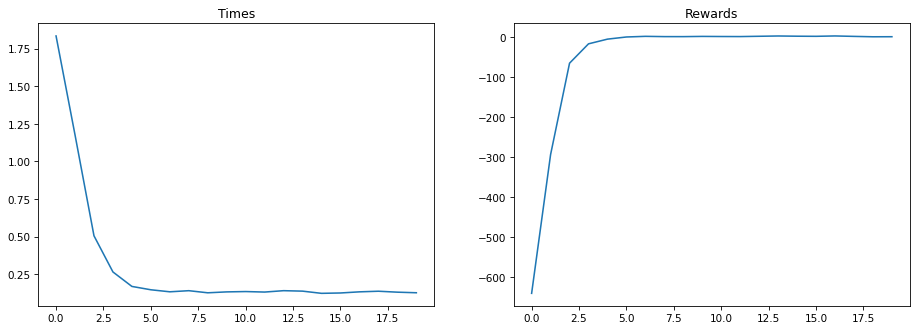

In [35]:
tot_epochs_train=2000 # number fo epochs
max_epoch_step=200 # number of steps to terminate an epoch

# train the agent
mEnv.train(tot_epochs_train, max_epoch_step, print_info=True, print_info_episodes=100)

# plot time exection and rewards over time
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=75)
ax[0].title.set_text("Times")
ax[0].plot(mEnv.times)
ax[1].title.set_text("Rewards")
ax[1].plot(mEnv.rewards)
plt.show()

step:  0
current_observation:  192
action:  0


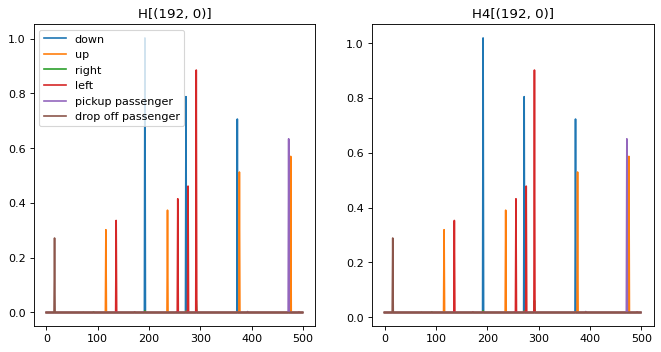

step:  1
current_observation:  292
action:  3


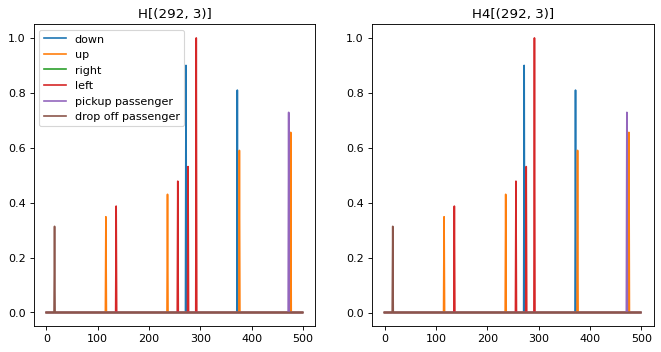

step:  2
current_observation:  272
action:  0


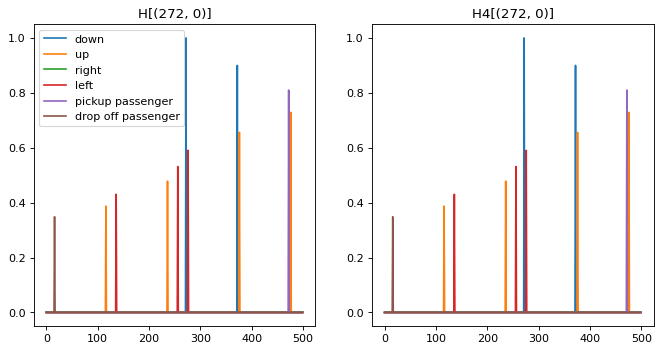

step:  3
current_observation:  372
action:  0


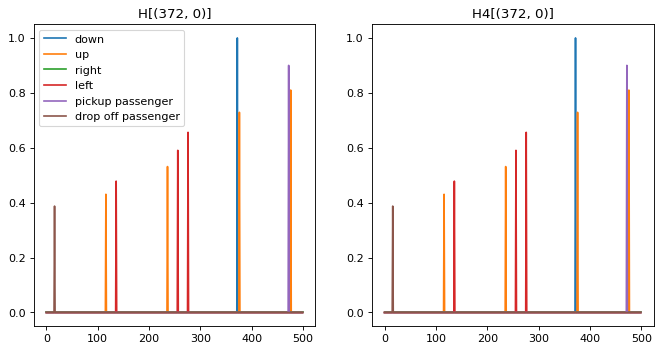

step:  4
current_observation:  472
action:  4


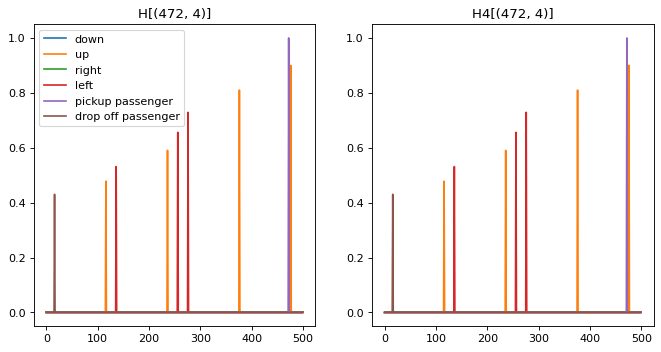

step:  5
current_observation:  476
action:  1


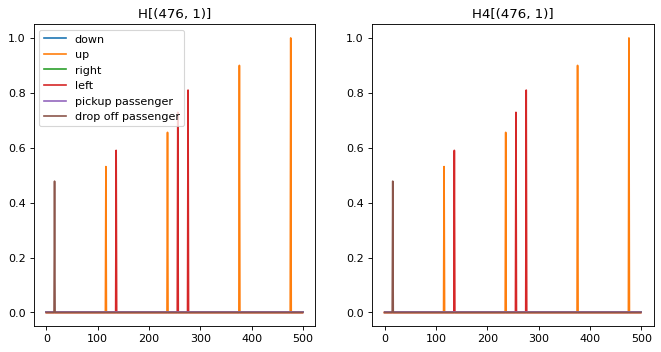

step:  6
current_observation:  376
action:  1


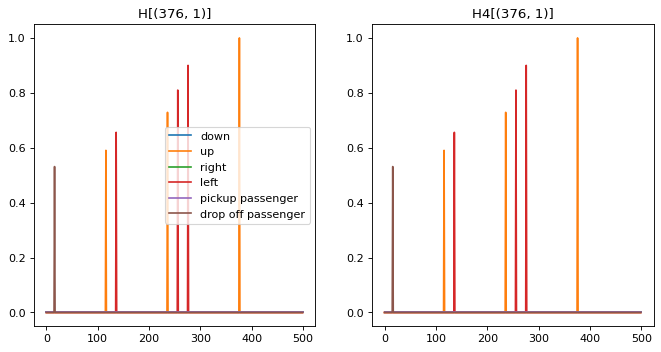

step:  7
current_observation:  276
action:  3


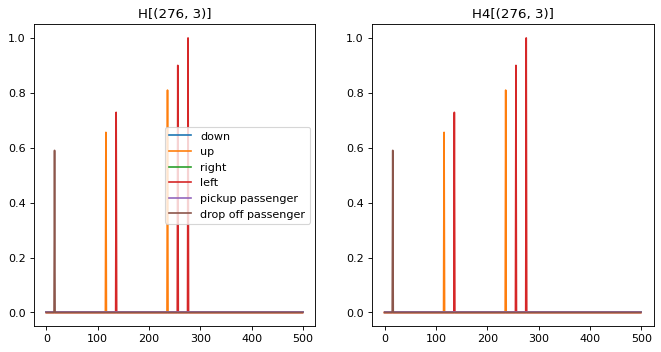

step:  8
current_observation:  256
action:  3


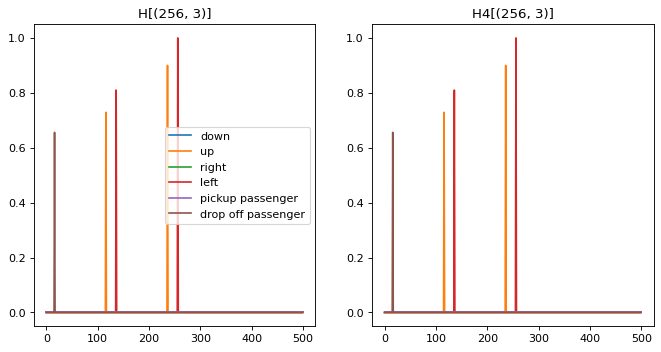

step:  9
current_observation:  236
action:  1


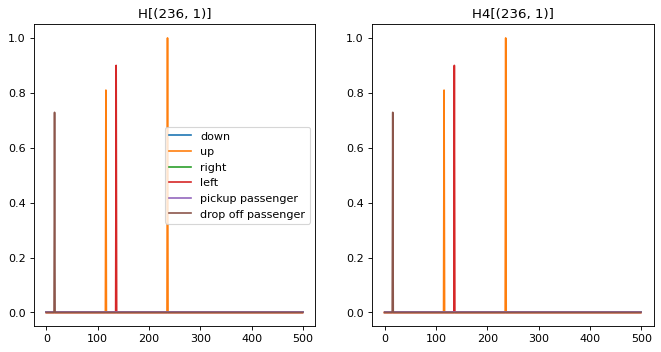

step:  10
current_observation:  136
action:  3


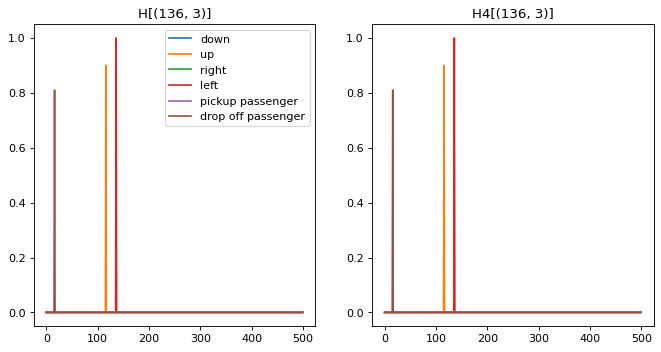

step:  11
current_observation:  116
action:  1


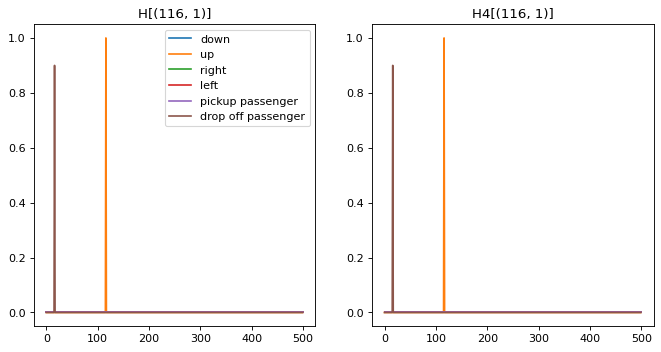

step:  12
current_observation:  16
action:  5


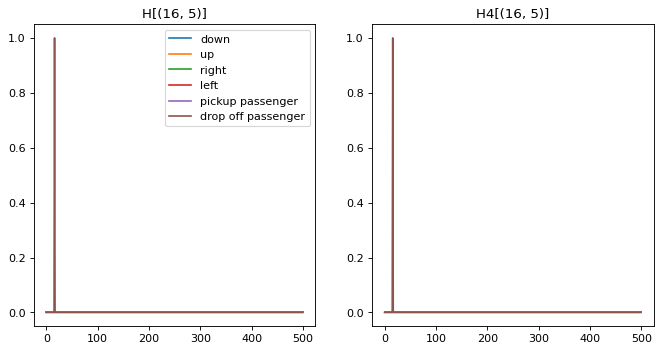

In [36]:
mEnv.test() # test the agent